In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import string
import contractions

from sklearn.decomposition import NMF

from collections import Counter
%matplotlib inline

# 1... Explore a few of the json files

In [2]:
first_doc = json.load(open("data/2018_01/news_0042050.json", encoding='utf8')) # randomly picked one from 2018.01
first_doc

{'organizations': [],
 'uuid': 'adef5703808698823c07f369e534e3f28e9364ce',
 'thread': {'social': {'gplus': {'shares': 0},
   'pinterest': {'shares': 0},
   'vk': {'shares': 0},
   'linkedin': {'shares': 0},
   'facebook': {'likes': 0, 'shares': 0, 'comments': 0},
   'stumbledupon': {'shares': 0}},
  'site_full': 'www.reuters.com',
  'main_image': 'https://s4.reutersmedia.net/resources_v2/images/rcom-default.png',
  'site_section': 'http://www.reuters.com/resources/archive/us/20180124.html',
  'section_title': 'Archive News &amp; Video for Wednesday, 24 Jan 2018 | Reuters.com',
  'url': 'https://www.reuters.com/article/brief-qatars-ezdan-holding-board-says-no/brief-qatars-ezdan-holding-board-says-no-dividend-for-2017-idUSL4N1PK1XY',
  'country': 'US',
  'domain_rank': 408,
  'title': "BRIEF-Qatar's Ezdan Holding Board Says No Dividend For 2017",
  'performance_score': 0,
  'site': 'reuters.com',
  'participants_count': 1,
  'title_full': '',
  'spam_score': 0.0,
  'site_type': 'news',
 

In [3]:
first_doc['text'] # key for the body of the article

'Jan 25 (Reuters) - EZDAN HOLDING GROUP:\n* BOARD DECIDES TO RETAIN 2017 PROFIT AND NOT TO DISTRIBUTE DIVIDENDS FOR THE YEAR\u200d\u200b Source:( bit.ly/2FcBiW4 ) Further company coverage:\n '

- this article is really short, just an annoucement with a link to the source; source is in Arabic and is another short article.
- it's not completely uninformative: says that Ezdan Holding Group will not distribute dividends

In [4]:
len(first_doc['text'])

178

In [5]:
# 2nd article sample
second_doc = json.load(open("data/2018_01/news_0022607.json", encoding='utf8')) # randomly picked one from 2018.01
second_doc

{'organizations': [],
 'uuid': '0b07efb5660b867abecd9cb88a2abee5bf4278e9',
 'thread': {'social': {'gplus': {'shares': 0},
   'pinterest': {'shares': 0},
   'vk': {'shares': 0},
   'linkedin': {'shares': 0},
   'facebook': {'likes': 0, 'shares': 0, 'comments': 0},
   'stumbledupon': {'shares': 0}},
  'site_full': 'www.reuters.com',
  'main_image': 'https://s4.reutersmedia.net/resources_v2/images/rcom-default.png',
  'site_section': 'http://www.reuters.com/resources/archive/us/20180115.html',
  'section_title': 'Archive News &amp; Video for Monday, 15 Jan 2018 | Reuters.com',
  'url': 'https://www.reuters.com/article/brief-brightpath-biotherapeutics-says-ex/brief-brightpath-biotherapeutics-says-exercise-of-options-idUSL3N1PA2FF',
  'country': 'US',
  'domain_rank': 408,
  'title': 'BRIEF-BrightPath Biotherapeutics says exercise of options',
  'performance_score': 0,
  'site': 'reuters.com',
  'participants_count': 1,
  'title_full': '',
  'spam_score': 0.238,
  'site_type': 'news',
  'pu

- looks like some of the articles are relatively short, more like tweets/headlines 
- there's other data in the dictionary include title, date published, url, author

In [6]:
print(second_doc['title'])
print(second_doc['author'])
print(second_doc['published'])
print(second_doc['text'])

BRIEF-BrightPath Biotherapeutics says exercise of options
Reuters Editorial
2018-01-15T14:24:00.000+02:00
Jan 15 (Reuters) - BrightPath Biotherapeutics Co Ltd :
* Says 15,000 units of its 12th series options were exercised to 1.5 million shares of its common stock, at price of 757 yen per share, on Jan. 15
Source text in Japanese: goo.gl/W4jktq
Further company coverage: (Beijing Headline News)
 


In [7]:
# 3rd article sample
third_doc = json.load(open("data/2018_01/news_0000865.json", encoding='utf8')) # randomly picked one from 2018.01
third_doc

{'organizations': [],
 'uuid': '7b4ccc1a65223aaaa24893db0fa72b7c2f6c4cdb',
 'thread': {'social': {'gplus': {'shares': 0},
   'pinterest': {'shares': 0},
   'vk': {'shares': 0},
   'linkedin': {'shares': 0},
   'facebook': {'likes': 24, 'shares': 24, 'comments': 0},
   'stumbledupon': {'shares': 0}},
  'site_full': 'uk.reuters.com',
  'main_image': 'https://s4.reutersmedia.net/resources/r/?m=02&d=20180102&t=2&i=1218908575&w=1200&r=LYNXMPEE010ZV',
  'site_section': 'http://feeds.reuters.com/reuters/UKSportsNews/',
  'section_title': 'Reuters: Sports News',
  'url': 'https://uk.reuters.com/article/uk-soccer-england-cry/palace-duo-out-for-the-season-after-fouls-on-de-bruyne-idUKKBN1ER1VN',
  'country': 'US',
  'domain_rank': 408,
  'title': 'Palace duo out for the season after fouls on De Bruyne',
  'performance_score': 0,
  'site': 'reuters.com',
  'participants_count': 0,
  'title_full': '',
  'spam_score': 0.0,
  'site_type': 'news',
  'published': '2018-01-03T00:58:00.000+02:00',
  're

- not all of the documents are financial news articles, it includes sports
- this is a soccer/football news article

In [8]:
# for the 3rd document, create dictionary with just the title, text, date published
imports_dct = dict()
imports_dct['title'] = third_doc['title']
imports_dct['text'] = third_doc['text']
imports_dct['date'] = third_doc['published']
imports_dct

{'title': 'Palace duo out for the season after fouls on De Bruyne',
 'text': "January 2, 2018 / 11:00 PM / Updated 11 minutes ago Palace duo out for the season after fouls on De Bruyne Reuters Staff 1 Min Read \nSOUTHAMPTON, England (Reuters) - Crystal Palace manager Roy Hodgson confirmed defender Scott Dann and midfielder Jason Puncheon will miss the rest of the season after suffering knee injuries against Manchester City on Sunday. Soccer Football - Premier League - Southampton vs Crystal Palace - St Mary's Stadium, Southampton, Britain - January 2, 2018 Crystal Palace manager Roy Hodgson celebrates after the match Action Images via Reuters/Peter Cziborra \nBoth were booked for fouls on Kevin de Bruyne which led to their respective injuries in the 0-0 Premier League draw and forced them both off the pitch. \n“It’s very bad news. Dann is an anterior cruciate ligament and Puncheon a rupture in the posterior cruciate ligament,” Hodgson told a news conference after Palace’s 2-1 win over 

# 2... Create DF of all the articles from Jan to May, 2018
- title, text, date published
- examine articles of different lengths
- filter length of articles appropriately

In [9]:
json_files = os.listdir("data/2018_01") # list of all json filenames for January
len(json_files)

57802

In [10]:
# february through march
for i in range(2,6):
    json_files.extend(os.listdir("data/2018_0" + str(i)))
len(json_files) # about 5 times, good

306242

In [11]:
%%time

lst_dct = list()

json_files = os.listdir("data/2018_01") # list of all json filenames for January
print(len(json_files))

for file in json_files:
    temp_dct = dict()
    article = json.load(open(r"data/2018_01/" + file, encoding='utf8'), )
    
    # UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 2608: character maps to <undefined>
    # it's trying to convert to ascii, but can't decode something; need to add parameter "encoding='utf8'"
    
    temp_dct['title'] = article['title']
    temp_dct['text'] = article['text']
    temp_dct['date'] = article['published']
    lst_dct.append(temp_dct)

57802
Wall time: 6min 24s


In [12]:
%%time
json_files = os.listdir("data/2018_02") # list of all json filenames for January
print(len(json_files))

for file in json_files:
    temp_dct = dict()
    article = json.load(open(r"data/2018_02/" + file, encoding='utf8'), )
    temp_dct['title'] = article['title']
    temp_dct['text'] = article['text']
    temp_dct['date'] = article['published']
    lst_dct.append(temp_dct)

64592
Wall time: 6min 45s


In [13]:
%%time
json_files = os.listdir("data/2018_03") # list of all json filenames for January
print(len(json_files))

for file in json_files:
    temp_dct = dict()
    article = json.load(open(r"data/2018_03/" + file, encoding='utf8'), )
    temp_dct['title'] = article['title']
    temp_dct['text'] = article['text']
    temp_dct['date'] = article['published']
    lst_dct.append(temp_dct)

57456
Wall time: 6min 11s


In [14]:
%%time
json_files = os.listdir("data/2018_04") # list of all json filenames for January
print(len(json_files))

for file in json_files:
    temp_dct = dict()
    article = json.load(open(r"data/2018_04/" + file, encoding='utf8'), )
    temp_dct['title'] = article['title']
    temp_dct['text'] = article['text']
    temp_dct['date'] = article['published']
    lst_dct.append(temp_dct)

63245
Wall time: 6min 7s


In [15]:
%%time
json_files = os.listdir("data/2018_05") # list of all json filenames for January
print(len(json_files))

for file in json_files:
    temp_dct = dict()
    article = json.load(open(r"data/2018_05/" + file, encoding='utf8'), )
    temp_dct['title'] = article['title']
    temp_dct['text'] = article['text']
    temp_dct['date'] = article['published']
    lst_dct.append(temp_dct)

63147
Wall time: 6min 8s


In [16]:
print("DONE")
len(lst_dct)

DONE


306242

In [17]:
%%time
lst_dct = list() # list of dictionaries each representing a doc; all 5 months

for month in range(1,6):
    json_files_tmp = os.listdir("data/2018_0{0}".format(month))
    
    for file in json_files_tmp:
        temp_dct = dict()
        article = json.load(open("data/2018_0{0}/".format(month) + file, encoding='utf8'), )

        # UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 2608: character maps to <undefined>
        # it's trying to convert to ascii, but can't decode something; need to add parameter "encoding='utf8'"

        temp_dct['title'] = article['title']
        temp_dct['text'] = article['text']
        temp_dct['date'] = article['published']
        lst_dct.append(temp_dct)

Wall time: 27min 11s


In [18]:
# print("DONE")
# len(json_files_tmp)

In [19]:
print(file) # last file name (should be last file in May directory)
print(len(lst_dct))
lst_dct[55] # key into one of the documents

news_0063140.json
306242


{'title': 'Auto troubles in 2018? 5 trades',
 'text': 'Auto troubles in 2018? 5 trades 3 Hours Ago',
 'date': '2018-01-03T00:00:00.000+02:00'}

In [21]:
# 56th document is really short, did it import correctly? check the json file...
fourth_one = json.load(open("data/2018_01/blogs_0002321.json", encoding='utf8')) # used file explorer to find the 56th article sorted alphabetically; 'blogs_0002321.json' is the 56th article.
fourth_one

# it imported correctly

{'organizations': [],
 'uuid': '21360879ababa90e65a8cb49eb127f73c22e44c6',
 'thread': {'social': {'gplus': {'shares': 0},
   'pinterest': {'shares': 0},
   'vk': {'shares': 0},
   'linkedin': {'shares': 0},
   'facebook': {'likes': 0, 'shares': 0, 'comments': 0},
   'stumbledupon': {'shares': 0}},
  'site_full': 'www.cnbc.com',
  'main_image': 'https://fm.cnbc.com/applications/cnbc.com/resources/img/editorial/2017/04/26/104428540-GettyImages-476603973.600x400.jpg',
  'site_section': 'http://www.cnbc.com/id/10001135/device/rss/rss.html',
  'section_title': 'Stock Picks',
  'url': 'https://www.cnbc.com/video/2018/01/02/auto-troubles-in-2018-5-trades.html',
  'country': 'US',
  'domain_rank': 767,
  'title': 'Auto troubles in 2018? 5 trades',
  'performance_score': 0,
  'site': 'cnbc.com',
  'participants_count': 0,
  'title_full': '',
  'spam_score': 0.0,
  'site_type': 'blogs',
  'published': '2018-01-03T00:00:00.000+02:00',
  'replies_count': 0,
  'uuid': '21360879ababa90e65a8cb49eb127

# issue:
- the text for this is simply:  
'Auto troubles in 2018? 5 trades 3 Hours Ago'
- it's just a link to a video (CNBC):
https://www.cnbc.com/video/2018/01/02/auto-troubles-in-2018-5-trades.html

In [22]:
pd.options.display.max_colwidth = 2000 # display.max_colwidth sets the maximum width of columns. Cells of this length or longer will be truncated with an ellipsis.
pd.options.display.max_columns = 500 # max_columns sets the maximum number of rows and columns displayed when a frame is pretty-printed. Truncated lines are replaced by an ellipsis.

df = pd.DataFrame(lst_dct)
df

,title,text,date
0,"Emerging markets are set for an even bigger rally in 2018, says one technician","17 Hours Ago | 02:56 \nEmerging markets soared more than 33 percent in 2017, and Todd Gordon of TradingAnalysis.com says the rally won't stop. \nA big part of the rally in emerging markets, tracked by the emerging market ETF EEM , was a weak dollar. And given that Gordon still sees the inverse relationship between EEM and the dollar, measured in his charts by the dollar-tracking ETF UUP , he believes the U.S. currency will continue to help the group. \n""We have a falling U.S. dollar, which will support international and emerging market currencies and will give those EEM stocks a boost,"" Gordon said Tuesday on CNBC's ""Trading Nation."" The U.S. dollar in 2017 posted its worst annual performance in 14 years, while EEM saw its best performance since 2013. \nAs for how high the latter could go, Gordon says EEM has broken ""resistance"" at around $45, which was the ETF's 2014 highs. That $45 region is now what he calls ""support,"" and he sees it rallying to $50, which the ETF hasn't hit since mid-2011. \nTo play for a move higher, Gordon suggested buying the February 48/50 call spread for 72 cents, or $72 per options contract. This means that if EEM closes above $50 on Feb. 16, then Gordon could make a maximum reward of $128 on the trade. \nBut if EEM were to close below $48, then Gordon would lose the $72 he paid for the trade. As a result, Gordon wants to establish a point at which to get out. \n""If the 72 cent premium we just laid out gets cut in half to about 36 cents, let's cut the trade and move on,"" he said. \nEEM started the year off strong, rallying more than 1 percent on Tuesday.",2018-01-03T15:00:00.000+02:00
1,Cramer reflects on how Trump's actions are fueling the 'beast' market rally,"Cramer reflects on how Trump's actions are fueling the 'beast' market rally 1 Hour Ago Jim Cramer examined the notion that investors are ""bored"" with the market rally and explained how the president is driving stocks higher.",2018-01-03T01:34:00.000+02:00
2,The Wall Street Journal: Peter Thiel’s VC firm has made a monster bet on bitcoin,"Published: Jan 2, 2018 5:59 p.m. ET Share \nFew mainstream investors have bought large sums of bitcoin, scared off by concerns about cybersecurity and liquidity Getty Images \nBy Rob Copeland \nOne of the biggest names in Silicon Valley is placing a moonshot bet on bitcoin BTCUSD, +0.72% . \nFounders Fund, the venture-capital firm co-founded by Peter Thiel, has amassed hundreds of millions of dollars of the volatile cryptocurrency, people familiar with the matter said. The bet has been spread across several of the firm’s most recent funds, the people said, including one that began investing in mid-2017 and made bitcoin one of its first investments. \nFounders and Thiel, 50 years old, are well-known for early investments in companies like Facebook Inc. FB, +2.81% that sometimes take years to come to fruition. The bitcoin bet is quickly showing promise. Founders bought around $15 million to $20 million in bitcoin, and it has told investors the firm’s haul is now worth hundreds of millions of dollars after the digital currency’s ripping rise in the past year. \nIt isn’t clear if Founders has sold any of its holdings yet. The bet hasn’t been previously reported.",2018-01-03T00:59:00.000+02:00
3,Hoda Kotb Will Replace Matt Lauer on NBC’s ‘Today’ Show,"By Reuters 8:23 AM EST \nTelevision host Hoda Kotb was named the new co-anchor of the NBC News Today show on Tuesday, replacing former co-host Matt Lauer several weeks after the longtime anchor was fired for inappropriate sexual behavior , according to a network statement. \nKotb will join Savannah Guthrie during the first two hours of the popular program, starting at 7 a.m. EST (noon GMT), and become the first pair of women to host the show along with weatherman Al Roker and Orange Room host Carson Daly. Kotb will continue co-hosting the 10 a.m. hour of T

In [23]:
# examine sample of 25 articles

pd.options.display.max_colwidth = 800
pd.options.display.max_columns = 500
df.sample(25, random_state = 99)

,title,text,date
25497,Barca's Dembele suffers another hamstring injury,"55 PM / Updated 8 minutes ago Barca's Dembele suffers another hamstring injury \nMADRID (Reuters) - Barcelona forward Ousmane Dembele has suffered another hamstring injury and will be out of action for between three and four weeks, the La Liga leaders said on Monday. Soccer Football - La Liga Santander - Barcelona vs Levante - Camp Nou, Barcelona, Spain - January 7, 2018 Barcelona's Ousmane Dembele appluads the fans as he is substituted off REUTERS/Albert Gea \nThe French winger, signed last year from Borussia Dortmund for a fee which could rise to 147 million euros, suffered a hamstring tear in September that kept him out until January. \nDembele featured in four games after returning, starting one, before suffering a new problem in the 4-2 win over Real Sociedad on Sunday. \n“Test...",2018-01-15T15:52:00.000+02:00
135560,Boeing executive rules out reviving 767 passenger jet,"PARIS (Reuters) - Boeing Co ( BA.N ) on Monday ruled out reviving its dormant 767 passenger plane as it continues to ponder options for a potential new niche in the middle of the aircraft market.\nFILE PHOTO: Boeing's logo is seen during the Japan Aerospace 2016 air show in Tokyo, Japan, October 12, 2016. REUTERS/Kim Kyung-Hoon/File Photo “Bringing back the 767 (passenger version) - I just don’t see it,” Randy Tinseth, vice-president of commercial marketing, told reporters on a conference call.\nThere has been some speculation Boeing would revive the 767 wide-body passenger line to offer airlines a low-price backstop in case a proposed brand-new mid-market plane suffered delays, or in case Boeing decided not to go ahead with that project.\nBoeing continues to target 2024-25 for entry i...",2018-03-06T04:27:00.000+02:00
193818,The New York Fed makes a controversial pick,The New York Fed makes a controversial pick 10:20am EDT - 01:39 \nThe powerful Federal Reserve Bank of New York has picked John Williams as its next president. A controversial pick because of his lack of Wall Street knowledge and the bank's failure at diversity. \nThe powerful Federal Reserve Bank of New York has picked John Williams as its next president. A controversial pick because of his lack of Wall Street knowledge and the bank's failure at diversity. //reut.rs/2Jig3oA,2018-04-04T17:20:00.000+03:00
82337,"BRIEF-Daré Bioscience Enters Into Agreement To License SST-6007, A Potential Treatment For FSAD","11 PM / in 8 minutes BRIEF-Daré Bioscience Enters Into Agreement To License SST-6007, A Potential Treatment For FSAD Reuters Staff 1 Min Read \nFeb 12 (Reuters) - Dare Bioscience Inc: \n* DARÉ BIOSCIENCE, INC. ENTERS INTO LICENSE AND COLLABORATION AGREEMENT FOR A PRODUCT WITH THE POTENTIAL TO RECEIVE THE FIRST FDA APPROVAL FOR FEMALE SEXUAL AROUSAL DISORDER \n* DARE BIOSCIENCE INC - ‍ENTERED INTO AN AGREEMENT TO LICENSE SST-6007​ \n* DARE BIOSCIENCE INC - ‍DARÉ ANTICIPATES COMMENCING A PHASE 2B CLINICAL TRIAL IN SECOND HALF OF 2018 FOR SST-6007​ Source text for Eikon:",2018-02-12T15:08:00.000+02:00
98551,Forex market: Dollar moves in focus,"The dollar enjoyed a small rebound on Monday as investors bought back the greenback following its plunge to three-year lows.\nThe U.S. currency has been hurt by a variety of factors this year, including concerns that Washington might pursue a weak dollar strategy and the perceived erosion of its yield advantage as other countries start to scale back easy monetary policy.\nConfidence in the dollar has also been shaken by mounting worries over the U.S. budget deficit, which is projected to balloon to $1 trillion in 2019 amid a government spending splurge and large corporate tax cuts.\nThe return of risk appetite last week after a big stock market fall in early February had also been detrimental to the dollar, but on Monday the U.S. currency found its feet as some investors bought the dol...",2018-02-19T04:18:00.000+02:00
225067,Instagram Stories Just Got Way Easier to Mass Upload 

In [24]:
def wordcount(text):
    word_lst = list()
    word_lst = text.split()
    return len(word_lst)

In [25]:
df['wordcount'] = df.text.apply(wordcount)
df

,title,text,date,wordcount
0,"Emerging markets are set for an even bigger rally in 2018, says one technician","17 Hours Ago | 02:56 \nEmerging markets soared more than 33 percent in 2017, and Todd Gordon of TradingAnalysis.com says the rally won't stop. \nA big part of the rally in emerging markets, tracked by the emerging market ETF EEM , was a weak dollar. And given that Gordon still sees the inverse relationship between EEM and the dollar, measured in his charts by the dollar-tracking ETF UUP , he believes the U.S. currency will continue to help the group. \n""We have a falling U.S. dollar, which will support international and emerging market currencies and will give those EEM stocks a boost,"" Gordon said Tuesday on CNBC's ""Trading Nation."" The U.S. dollar in 2017 posted its worst annual performance in 14 years, while EEM saw its best performance since 2013. \nAs for how high the latter could...",2018-01-03T15:00:00.000+02:00,293
1,Cramer reflects on how Trump's actions are fueling the 'beast' market rally,"Cramer reflects on how Trump's actions are fueling the 'beast' market rally 1 Hour Ago Jim Cramer examined the notion that investors are ""bored"" with the market rally and explained how the president is driving stocks higher.",2018-01-03T01:34:00.000+02:00,37
2,The Wall Street Journal: Peter Thiel’s VC firm has made a monster bet on bitcoin,"Published: Jan 2, 2018 5:59 p.m. ET Share \nFew mainstream investors have bought large sums of bitcoin, scared off by concerns about cybersecurity and liquidity Getty Images \nBy Rob Copeland \nOne of the biggest names in Silicon Valley is placing a moonshot bet on bitcoin BTCUSD, +0.72% . \nFounders Fund, the venture-capital firm co-founded by Peter Thiel, has amassed hundreds of millions of dollars of the volatile cryptocurrency, people familiar with the matter said. The bet has been spread across several of the firm’s most recent funds, the people said, including one that began investing in mid-2017 and made bitcoin one of its first investments. \nFounders and Thiel, 50 years old, are well-known for early investments in companies like Facebook Inc. FB, +2.81% that sometimes take yea...",2018-01-03T00:59:00.000+02:00,192
3,Hoda Kotb Will Replace Matt Lauer on NBC’s ‘Today’ Show,"By Reuters 8:23 AM EST \nTelevision host Hoda Kotb was named the new co-anchor of the NBC News Today show on Tuesday, replacing former co-host Matt Lauer several weeks after the longtime anchor was fired for inappropriate sexual behavior , according to a network statement. \nKotb will join Savannah Guthrie during the first two hours of the popular program, starting at 7 a.m. EST (noon GMT), and become the first pair of women to host the show along with weatherman Al Roker and Orange Room host Carson Daly. Kotb will continue co-hosting the 10 a.m. hour of Today with Kathie Lee Gifford. \n“It’s 2018 and we are kicking off the year right because Hoda is officially the co-anchor of Today,” said Guthrie, 46, who announced the news during the program’s opening moments. \nKotb, 53, quickly fi...",2018-01-02T15:23:00.000+02:00,311
4,UK's Compass says new CEO to start Jan 1 after death of Cousins - Reuters,"January 1, 2018 / 8:56 AM / Updated 5 hours ago UK's Compass says new CEO to start Jan 1 after death of Cousins Reuters Staff 1 Min Read \nJan 1 (Reuters) - Britain’s Compass, the world’s biggest catering firm, said incoming chief executive Dominic Blakemore would start his tenure three months earlier than expected on January 1 after the death of outgoing CEO Richard Cousins. \nCousins, 58, and four family members along with the pilot were killed when the seaplane they were travelling in crashed in Australia on New Year’s Eve. (Reporting by Elisabeth O‘Leary; editing by Jason Neely)",2018-01-01T11:03:00.000+02:00,100
...,...,...,...,...
306237,Ejaz Elahi Rejoins Dresner Partners as Managing Director Healthcare,"CHICAGO, May 30, 2018 (GLOBE NEWSWIRE) -- Dresner Partners, a leading FINRA-registered, middle-mark

<AxesSubplot:>

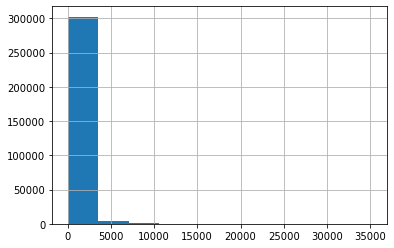

In [26]:
df.wordcount.hist()

In [27]:
df.wordcount.describe()

count    306242.000000
mean        401.886247
std         735.195210
min           0.000000
25%          71.000000
50%         223.000000
75%         476.000000
max       35218.000000
Name: wordcount, dtype: float64

- 75% of the articles are between 74 and 459 words (interquartile range)

<AxesSubplot:>

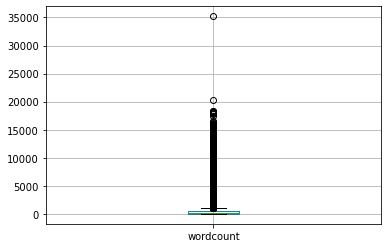

In [28]:
df.boxplot(column = 'wordcount')

- take a look at the really long documents

In [29]:
df_20000 = df[(df.wordcount > 5000) & (df.wordcount < 50000)]
print(df_20000.shape)
df_20000

(1782, 4)


,title,text,date,wordcount
34687,Synovus Announces Earnings for the Fourth Quarter 2017 and a 67% Increase in Quarterly Common Dividend,"Diluted Earnings per Share of $0.23 vs. $0.54 in 4Q16\nAdjusted Diluted Earnings per Share of $0.72 vs. $0.54 in 4Q16\nCOLUMBUS, Ga.--(BUSINESS WIRE)-- Synovus Financial Corp. (NYSE: SNV) today reported financial results for the quarter and year ended December 31, 2017.\nNet income available to common shareholders for the fourth quarter 2017 was $27.0 million or $0.23 per diluted share as compared to $95.4 million or $0.78 per diluted share for the third quarter 2017 and $66.0 million or $0.54 per diluted share for the fourth quarter 2016. Fourth quarter 2017 results include a $23.2 million loss on early extinguishment of debt, as well as a $47.2 million charge related to Federal tax reform. 1 Adjusted earnings per diluted share for the fourth quarter 2017 was $0.72, a 10.7% increase f...",2018-01-23T14:30:00.000+02:00,6970
34826,TrustCo Announces Fourth Quarter and Full Year 2017 Results; Net Income Before Taxes Up 12.9% Over Prior Year Quarter,"Executive Snapshot:\nContinued solid financial results: Key metrics for fourth quarter and full year 2017: Income before taxes of $19.7 million in the fourth quarter of 2017, up 12.9% compared to $17.5 million in the fourth quarter of 2016 Income before taxes of $76.7 million for the full year 2017, up 12.4% compared to $68.3 million for 2016 Net income rose for the full year 2017 over 2016 despite a $5.1 million charge related to the recently enacted federal tax legislation Return on average assets (ROAA) of 0.60% compared to 0.89% in the fourth quarter of 2016 Return on average equity (ROAE) of 6.38% compared to 9.87% in the fourth quarter of 2016 Efficiency ratio of 53.13% compared to 54.65% in the fourth quarter of 2016 (Non-GAAP measure; see P. 14 for definition)\nAsset quality re...",2018-01-23T00:01:00.000+02:00,6346
35547,F.N.B. Corporation Reports Fourth Quarter and Full Year 2017 Earnings,"PITTSBURGH, F.N.B. Corporation (NYSE: FNB) reported earnings for the fourth quarter of 2017 with net income available to common stockholders of $22.1 million, or $0.07 per diluted common share. Comparatively, third quarter of 2017 net income available to common stockholders totaled $75.7 million, or $0.23 per diluted common share, and fourth quarter of 2016 net income available to common stockholders totaled $49.3 million, or $0.23 per diluted common share. For the full year of 2017 net income available to common stockholders was $191.2 million or $0.63 per diluted common share compared to full year of 2016 of $162.9 million or $0.78 per diluted common share.\nFourth quarter operating net income per diluted common share (non-GAAP) was $0.24, which excludes the after-tax impact of merge...",2018-01-23T13:59:00.000+02:00,7608
35790,RBB Bancorp Reports Fourth Quarter Earnings for 2017,"LOS ANGELES, Jan. 22, 2018 /PRNewswire/ -- RBB Bancorp (NASDAQ:RBB) and its subsidiaries, Royal Business Bank (""the Bank"") and RBB Asset Management Company (""RAM""), collectively referred to herein as ""the Company"", announced financial results for the quarter ended December 31, 2017.\nThe Company reported net income of $4.9 million, or $0.29 diluted earnings per share, for the three months ended December 31, 2017, compared to net income of $6.6 million, or $0.42 diluted earnings per share, and $5.4 million, or $0.39 diluted earnings per share, for the three months ended September 30, 2017 and December 31, 2016, respectively. Included in the fourth quarter 2017 results is a $2.4 million, or $0.14 per diluted share, write-down related to the reduction in the value of the Company's net def...",2018-01-23T01:15:00.000+02:00,6550
36034,Old National’s 4th quarter includes strong commercial loan growth and another successful partnership,"4 th Quarter 2017 Highlights:\nOrganic commercial and commercial real estate loan growth 1 of 10.1% annualized from 3 rd quarter of 2017 Cost o

In [30]:
# print(df[df.wordcount > 10000].shape)
df[df.wordcount < 25]

,title,text,date,wordcount
25,Copper prices set to continue gains in 2018,Copper prices set to continue gains in 2018 20 Hours Ago,2018-01-02T01:36:00.000+02:00,11
32,2018 ETF market predictions,00:54 00:54 | 3 Hrs Ago,2018-01-03T17:32:00.000+02:00,6
35,What are the nuances of China's planned tax on asset management products?,What are the nuances of China's planned tax on asset management products? 1 Hour Ago,2018-01-02T02:46:00.000+02:00,15
55,Auto troubles in 2018? 5 trades,Auto troubles in 2018? 5 trades 3 Hours Ago,2018-01-03T00:00:00.000+02:00,9
62,China 's large manufacturers are gaining size through overseas deals,China 's large manufacturers are gaining size through overseas deals 18 Hours Ago,2018-01-02T04:03:00.000+02:00,13
...,...,...,...,...
305884,Dow jumps more than 300 points after banks rebound,Dow jumps more than 300 points 1 Hour Ago,2018-05-30T22:35:00.000+03:00,9
305996,Micron cut to equal-weight at Morgan Stanley,Micron cut to equal-weight at Morgan Stanley 1 Hour Ago,2018-05-31T20:29:00.000+03:00,10
306192,Uber CEO Dara Khosrowshahi: Uber Eats is growing very quickly,Uber CEO Dara Khosrowshahi: Uber Eats is growing very quickly 6 Hours Ago,2018-05-31T17:36:00.000+03:00,13
306194,What’s making Professor Jeremy Siegel so cautious on the market?,What’s making Professor Jeremy Siegel so cautious on the market? 2 Hours Ago,2018-05-30T23:40:00.000+03:00,13


In [31]:
df

,title,text,date,wordcount
0,"Emerging markets are set for an even bigger rally in 2018, says one technician","17 Hours Ago | 02:56 \nEmerging markets soared more than 33 percent in 2017, and Todd Gordon of TradingAnalysis.com says the rally won't stop. \nA big part of the rally in emerging markets, tracked by the emerging market ETF EEM , was a weak dollar. And given that Gordon still sees the inverse relationship between EEM and the dollar, measured in his charts by the dollar-tracking ETF UUP , he believes the U.S. currency will continue to help the group. \n""We have a falling U.S. dollar, which will support international and emerging market currencies and will give those EEM stocks a boost,"" Gordon said Tuesday on CNBC's ""Trading Nation."" The U.S. dollar in 2017 posted its worst annual performance in 14 years, while EEM saw its best performance since 2013. \nAs for how high the latter could...",2018-01-03T15:00:00.000+02:00,293
1,Cramer reflects on how Trump's actions are fueling the 'beast' market rally,"Cramer reflects on how Trump's actions are fueling the 'beast' market rally 1 Hour Ago Jim Cramer examined the notion that investors are ""bored"" with the market rally and explained how the president is driving stocks higher.",2018-01-03T01:34:00.000+02:00,37
2,The Wall Street Journal: Peter Thiel’s VC firm has made a monster bet on bitcoin,"Published: Jan 2, 2018 5:59 p.m. ET Share \nFew mainstream investors have bought large sums of bitcoin, scared off by concerns about cybersecurity and liquidity Getty Images \nBy Rob Copeland \nOne of the biggest names in Silicon Valley is placing a moonshot bet on bitcoin BTCUSD, +0.72% . \nFounders Fund, the venture-capital firm co-founded by Peter Thiel, has amassed hundreds of millions of dollars of the volatile cryptocurrency, people familiar with the matter said. The bet has been spread across several of the firm’s most recent funds, the people said, including one that began investing in mid-2017 and made bitcoin one of its first investments. \nFounders and Thiel, 50 years old, are well-known for early investments in companies like Facebook Inc. FB, +2.81% that sometimes take yea...",2018-01-03T00:59:00.000+02:00,192
3,Hoda Kotb Will Replace Matt Lauer on NBC’s ‘Today’ Show,"By Reuters 8:23 AM EST \nTelevision host Hoda Kotb was named the new co-anchor of the NBC News Today show on Tuesday, replacing former co-host Matt Lauer several weeks after the longtime anchor was fired for inappropriate sexual behavior , according to a network statement. \nKotb will join Savannah Guthrie during the first two hours of the popular program, starting at 7 a.m. EST (noon GMT), and become the first pair of women to host the show along with weatherman Al Roker and Orange Room host Carson Daly. Kotb will continue co-hosting the 10 a.m. hour of Today with Kathie Lee Gifford. \n“It’s 2018 and we are kicking off the year right because Hoda is officially the co-anchor of Today,” said Guthrie, 46, who announced the news during the program’s opening moments. \nKotb, 53, quickly fi...",2018-01-02T15:23:00.000+02:00,311
4,UK's Compass says new CEO to start Jan 1 after death of Cousins - Reuters,"January 1, 2018 / 8:56 AM / Updated 5 hours ago UK's Compass says new CEO to start Jan 1 after death of Cousins Reuters Staff 1 Min Read \nJan 1 (Reuters) - Britain’s Compass, the world’s biggest catering firm, said incoming chief executive Dominic Blakemore would start his tenure three months earlier than expected on January 1 after the death of outgoing CEO Richard Cousins. \nCousins, 58, and four family members along with the pilot were killed when the seaplane they were travelling in crashed in Australia on New Year’s Eve. (Reporting by Elisabeth O‘Leary; editing by Jason Neely)",2018-01-01T11:03:00.000+02:00,100
...,...,...,...,...
306237,Ejaz Elahi Rejoins Dresner Partners as Managing Director Healthcare,"CHICAGO, May 30, 2018 (GLOBE NEWSWIRE) -- Dresner Partners, a leading FINRA-registered, middle-mark

- Let's take a look at some of these shorter documents.

In [32]:
df_temp = df[df.wordcount < 25]

In [33]:
df_temp.iloc[1] 

# only has the time, we need to filter this

title          2018 ETF market predictions
text               00:54 00:54 | 3 Hrs Ago
date         2018-01-03T17:32:00.000+02:00
wordcount                                6
Name: 32, dtype: object

In [34]:
df_temp.iloc[500].text

# only has an announcement with no information

'The Afternoon Rundown: January 11, 2018 1 Hour Ago'

Let's look at documents with that have greater than 25 words but less than 50

In [35]:
df_temp2 = df[(df.wordcount > 25) & (df.wordcount < 50)] # why bit-wise, '&'? 'and' results in error

In [36]:
df_temp2.sample(20).text

88454                                                                                                                                                                   Feb 14 (Reuters) - Bank of Spain:\n* Spanish banks borrowed 169.946 billion euros ($210.05 billion) from the European Central Bank in January.\n* * ($1 = 0.8091 euros) (Reporting by Madrid newsroom)\n 
179524                                                                                                                                                                        March 29(Reuters) - Glory Science Co Ltd :\n* Says it plans to pay cash dividend of T$2/share for 2017\nSource text in Chinese: goo.gl/95Gkdr\nFurther company coverage: (Beijing Headline News)\n 
233902                                                                                                                                                     April 26 (Reuters) - Corestate Capital Holding SA:\n* DGAP-NEWS: CORESTATE CAPITAL HOLDING S.A.: CORESTAT

In [37]:
df_temp3 = df[(df.wordcount > 25) & (df.wordcount < 30)]
print(df_temp3.shape)
df_temp3.sample(20).text

(5584, 4)


196261          Why this equities pro would rather 'embrace the volatility' 9:44   Hugh Young of Aberdeen Standard Investments also discusses the expectations ahead of this weekend's Boao forum in China.
31461                  Jan 16 (Reuters) - RAY SIGORTA:\n* FY 2017 ESTIMATED PREMIUM UP 24.30 PCT AT 706.9 MILLION LIRA YEAR-ON-YEAR\nSource text for Eikon:\nFurther company coverage: (Gdynia Newsroom)\n 
20716                            Jan 12 (Reuters) - Evershine Group Holdings Ltd:\n* ‍CHAN MING KEI HAS TENDERED HIS RESIGNATION AS EXECUTIVE DIRECTOR​ Source text for Eikon: Further company coverage:\n 
223833                           Barclays CEO escapes with fine, keeps job 23 Mins Ago CNBC's Wilfred Frost reports on the latest developments in the Barclays whistleblower case involving CEO Jes Staley.
225558                        Genesis Energy LP:\n* GENESIS ENERGY LP FILES FOR POTENTIAL MIXED SHELF OFFERING; SIZE NOT DISCLOSED - SEC FILING Source text ( bit.ly/2JfrTPQ ) Further c

### Filter articles to appropriate word length, adjust if necessary through topic modeling iterations.

In [38]:
df_25plus = df[df.wordcount > 25]
print(df.shape)
print(df_25plus.shape)
# only 57802 - 56295 = 1507 documents that are shorter than 25 words

(306242, 4)
(298118, 4)


In [39]:
df_25_1000 = df[(df.wordcount > 25) & (df.wordcount < 1000)]
print(df.shape)
print(df_25_1000.shape)

(306242, 4)
(279437, 4)


# 3... Preprocessing

In [40]:
df = df[(df.wordcount > 25) & (df.wordcount < 1000)]
df.shape

(279437, 4)

In [41]:
df = df.reset_index()

In [42]:
# %time
df['processed']=df['text']
df['processed']=df['processed'].str.lower()
df['processed'] = df['processed'].replace(r'http\S+', ' ', regex=True) # remove urls
df['processed']=df['processed'].apply(contractions.fix) # expand contractions
df['processed'] = df['processed'].replace(r'[^A-Za-z]+', ' ', regex=True) # remove special characters

Finalize Data Acquisition

By this point, you should have a significant corpus (if not, your whole corpus) prepared as a list of strings for vectorization. Recall, your final corpus should have an aggregated length of 100,000+ terms (e.g., 1K documents of 100 terms each). So, you should eventually have a list of strings, corpus, such that sum([len(d.split(' ')) for d in corpus]) > 100000.

In [43]:
print('The number of documents: ' + str(len(df['processed'])))

The number of documents: 279437


In [44]:
print('The aggregated length (i.e., total number of non-unique terms) of corpus: ' + str(sum([len(d.split(' ')) for d in df['processed']])))
sum([len(d.split(' ')) for d in df['processed']]) > 100000

The aggregated length (i.e., total number of non-unique terms) of corpus: 76469770


True

### stopwords list

In [12]:
# stopwords

# stop_words will be fed in as parameter when vectorizing
# new stop words will be added to 'more_stop_words' which will be included in 'stop_words' after seeing the top 30 words from each of the topics.
# this will be an iterative process



# nltk.download('stopwords')

# stop_words = stopwords.words('english') # list is slow to look up, cast as set
stop_words = stopwords.words('english')


more_stop_words = ['said',
         'year',
         'one',
         'first',
         'time',
         'like',
         'last',
         'also',
         'world',
         'would',
         'people',
         'could',
         'two',
         'new',
         'get',
         'back',
         'make',
         'second',
         'going',
#          'points': 7,
         'think',
         'years',
         'even',
#          'open': 7,
         'cnbc',
#          'apple': 7,
#          'percent': 11,
         'many',
#          'big': 7,
#          'good': 7,
         'company',
#          'business': 8,
         'companies',
#          'services': 6,
#          'financial': 9,
         'inc',
         'com',
         'group',
#          'industry': 6,
#          'management': 6,
#          'executive': 6,
#          'investment': 6,
#          'technology': 6,
#          'chief',
#          'global': 6,
#          'billion',
         'market',
#          'ceo': 6,
#          'president': 11,
#          'board': 6,
#          'firm',
         'based',
         'source',
#          'capital': 6,
#          'energy': 6,
         'including',
#          'trump': 5,
#          'government': 5,
#          'state',
#          'states',
#          'united',
#          'minister': 5,
         'reuters',
#          'house': 5,
         'told',
#          'north',
#          'donald': 5,
#          'united states': 5,
         'country',
#          'korea': 5,
#          'trade': 5,
#          'donald trump': 5,
#          'eu': 5,
#          'washington': 5,
#          'party': 5,
#          'security': 5,
#          'deal': 5,
         'jan',
         'jan reuters',
#          'million': 5,
#          'bank': 4,
         'coverage',
         'text',
#          'company coverage': 4,
         'source text',
#          'oil': 4,
#          'shares': 6,
#          'prices': 4,
#          'dollar': 4,
#          'growth': 4,
         'says',
         'since',
#          'expected': 4,
         'eikon',
#          'profit': 4,
         'text eikon',
         'ltd',
#          'index': 4,
         'january',
         'editing',
         'reporting',
         'min',
         'min read',
         'read',
         'updated',
         'ago',
         'staff',
         'minutes',
         'pm',
         'reuters staff',
         'staff min',
         'january pm',
         'minutes ago',
         'updated minutes',
         'pm updated',
         'city',
#          'south': 3,
         'monday',
#          'london': 3,
         'january updated',
#          'statements': 2,
         'forward',
         'looking',
#          'forward looking': 2,
#          'looking statements': 2,
#          'results': 2,
         'information',
#          'may': 2,
#          'call': 2,
#          'securities': 2,
#          'release': 2,
#          'conference': 2,
         'available',
#          'stock': 2,
#          'future': 2,
         'www',
#          'risks': 2,
#          'products': 2,
#          'factors': 2,
#          'acquisition': 2,
#          'income': 1,
#          'net': 1,
#          'quarter': 1,
#          'december': 1,
#          'tax': 1,
#          'interest': 1,
#          'total': 1,
#          'share': 1,
#          'per': 1,
#          'non': 1,
#          'assets': 1,
#          'loans': 1,
#          'ended': 1,
#          'gaap': 1,
#          'fourth quarter': 1,
#          'fourth': 1,
#          'per share': 1,
#          'earnings': 1,
#          'ended december': 1,
#          'average',
#          'compared',
#          'expense': 1,
#          'operating': 1,
#          'cash': 1,
#          'loan': 1,
#          'equity': 1,
#          'net income': 1})
                      ]


stop_words.extend(more_stop_words)


# Counter({'said': 25,
#          'year': 20,
#          'one': 10,
#          'first': 7,
#          'time': 9,
#          'like': 7,
#          'last': 19,
#          'also': 18,
#          'world': 7,
#          'would': 12,
#          'people': 15,
#          'could': 12,
#          'two': 10,
#          'new': 21,
#          'get': 7,
#          'back': 7,
#          'make': 7,
#          'second': 7,
#          'going': 7,
#          'points': 7,
#          'think': 7,
#          'years': 13,
#          'even': 7,
#          'open': 7,
#          'cnbc': 7,
#          'apple': 7,
#          'percent': 11,
#          'many': 7,
#          'big': 7,
#          'good': 7,
#          'company': 12,
#          'business': 8,
#          'companies': 6,
#          'services': 6,
#          'financial': 9,
#          'inc': 8,
#          'com': 8,
#          'group': 6,
#          'industry': 6,
#          'management': 6,
#          'executive': 6,
#          'investment': 6,
#          'technology': 6,
#          'chief': 6,
#          'global': 6,
#          'billion': 10,
#          'market': 10,
#          'ceo': 6,
#          'president': 11,
#          'board': 6,
#          'firm': 6,
#          'based': 6,
#          'source': 12,
#          'capital': 6,
#          'energy': 6,
#          'including': 8,
#          'trump': 5,
#          'government': 5,
#          'state': 5,
#          'states': 5,
#          'united': 5,
#          'minister': 5,
#          'reuters': 12,
#          'house': 5,
#          'told': 5,
#          'north': 5,
#          'donald': 5,
#          'united states': 5,
#          'country': 5,
#          'korea': 5,
#          'trade': 5,
#          'donald trump': 5,
#          'eu': 5,
#          'washington': 5,
#          'party': 5,
#          'security': 5,
#          'deal': 5,
#          'jan': 4,
#          'jan reuters': 4,
#          'million': 5,
#          'bank': 4,
#          'coverage': 4,
#          'text': 4,
#          'company coverage': 4,
#          'source text': 4,
#          'oil': 4,
#          'shares': 6,
#          'prices': 4,
#          'dollar': 4,
#          'growth': 4,
#          'says': 4,
#          'since': 4,
#          'expected': 4,
#          'eikon': 4,
#          'profit': 4,
#          'text eikon': 4,
#          'ltd': 4,
#          'index': 4,
#          'january': 5,
#          'editing': 3,
#          'reporting': 3,
#          'min': 3,
#          'min read': 3,
#          'read': 3,
#          'updated': 3,
#          'ago': 3,
#          'staff': 3,
#          'minutes': 3,
#          'pm': 3,
#          'reuters staff': 3,
#          'staff min': 3,
#          'january pm': 3,
#          'minutes ago': 3,
#          'updated minutes': 3,
#          'pm updated': 3,
#          'city': 3,
#          'south': 3,
#          'monday': 3,
#          'london': 3,
#          'january updated': 3,
#          'statements': 2,
#          'forward': 2,
#          'looking': 2,
#          'forward looking': 2,
#          'looking statements': 2,
#          'results': 2,
#          'information': 2,
#          'may': 2,
#          'call': 2,
#          'securities': 2,
#          'release': 2,
#          'conference': 2,
#          'available': 2,
#          'stock': 2,
#          'future': 2,
#          'www': 2,
#          'risks': 2,
#          'products': 2,
#          'factors': 2,
#          'acquisition': 2,
#          'income': 1,
#          'net': 1,
#          'quarter': 1,
#          'december': 1,
#          'tax': 1,
#          'interest': 1,
#          'total': 1,
#          'share': 1,
#          'per': 1,
#          'non': 1,
#          'assets': 1,
#          'loans': 1,
#          'ended': 1,
#          'gaap': 1,
#          'fourth quarter': 1,
#          'fourth': 1,
#          'per share': 1,
#          'earnings': 1,
#          'ended december': 1,
#          'average': 1,
#          'compared': 1,
#          'expense': 1,
#          'operating': 1,
#          'cash': 1,
#          'loan': 1,
#          'equity': 1,
#          'net income': 1})

In [13]:
'said' in stop_words

True

### lemmatization

In [46]:
nlp = spacy.load('en_core_web_sm') # loading some sort of pipeline... we're giving it a package to load <-- english trained on small dataset.

In [47]:
# lemmatize and tokenize, then remove stopwords, then concatenate, then feed into vectorizer...
# also filter by nouns only...

def lemmatize(document, stpwrds):
    temp_lst = list()
    doc = nlp(document)
    for token in doc:
        if token.pos_ == 'NOUN' and token.text not in stpwrds:
            temp_lst.append(token.lemma_)
    return " ".join(temp_lst)

In [48]:
%%time
df['lemma_stop'] = df['processed'].apply(lambda x: lemmatize(x, stop_words))

Wall time: 2h 52min 25s


In [67]:
print('DONE')

DONE


In [74]:
%%time
# lemmatization takes a long time, save/import df with lemmatized column.

# save dataframe to pickle file
df.to_pickle('df_5mo_2022.05.16_01.pkl')

# df.to_csv('df_5mo_2022.05.16_01.csv', encoding='utf-8', index=True) # save the index as well, as first column?

# df = pd.read_csv('df_with_lemma_stop_5months_2022.05.09_01.csv') # import saved version of df after lemmatizing with spaCy

Wall time: 2.08 s


In [18]:
df

,Unnamed: 0,index,title,text,date,wordcount,processed,lemma_stop
0,0,0,Emerging markets are set for an even bigger ra...,17 Hours Ago | 02:56 \nEmerging markets soared...,2018-01-03T15:00:00.000+02:00,293,hours ago emerging markets soared more than p...,hour market percent gordon tradinganalysis ral...
1,1,1,Cramer reflects on how Trump's actions are fue...,Cramer reflects on how Trump's actions are fue...,2018-01-03T01:34:00.000+02:00,37,cramer reflects on how trump s actions are fue...,cramer trump action beast rally hour notion in...
2,2,2,The Wall Street Journal: Peter Thiel’s VC firm...,"Published: Jan 2, 2018 5:59 p.m. ET Share \nFe...",2018-01-03T00:59:00.000+02:00,192,published jan p m et share few mainstream inve...,et share mainstream investor sum bitcoin conce...
3,3,3,Hoda Kotb Will Replace Matt Lauer on NBC’s ‘To...,By Reuters 8:23 AM EST \nTelevision host Hoda ...,2018-01-02T15:23:00.000+02:00,311,by reuters am est television host hoda kotb wa...,television host anchor today week anchor behav...
4,4,4,UK's Compass says new CEO to start Jan 1 after...,"January 1, 2018 / 8:56 AM / Updated 5 hours ag...",2018-01-01T11:03:00.000+02:00,100,january am updated hours ago uk s compass says...,hour ceo death cousin compass catering firm do...
...,...,...,...,...,...,...,...,...
279432,279432,306235,Schmitz Brings Extensive Commercial Banking Le...,"DUBUQUE, Iowa, May 30, 2018 (GLOBE NEWSWIRE) -...",2018-05-31T00:01:00.000+03:00,460,dubuque iowa may globe newswire heartland fina...,today member director director bank chairman b...
279433,279433,306236,"UPDATE 8-Oil climbs over 2 pct, shrugs off API...",* Indian refiner to halt oil imports from Iran...,2018-05-31T00:51:00.000+03:00,482,indian refiner to halt oil imports from iran ...,refiner oil import bank oil price stock report...
279434,279434,306237,Ejaz Elahi Rejoins Dresner Partners as Managin...,"CHICAGO, May 30, 2018 (GLOBE NEWSWIRE) -- Dres...",2018-05-30T23:14:00.000+03:00,657,chicago may globe newswire dresner partners a ...,partner finra investment bank member firm ejaz...
279435,279435,306238,UPDATE 1-Japan Post Insurance ready to buy sho...,"May 31, 2018 / 7:59 AM / Updated 2 minutes ago...",2018-05-31T12:01:00.000+03:00,456,may am updated minutes ago japan post insuranc...,insurance term debt tomo investor term governm...


In [19]:
print(df.iloc[1])

Unnamed: 0                                                    1
index                                                         1
title         Cramer reflects on how Trump's actions are fue...
text          Cramer reflects on how Trump's actions are fue...
date                              2018-01-03T01:34:00.000+02:00
wordcount                                                    37
processed     cramer reflects on how trump s actions are fue...
lemma_stop    cramer trump action beast rally hour notion in...
Name: 1, dtype: object


In [70]:
# look at df output above and fix index and get rid of unecessary columns created through the process of saving and importing csv
# to preserve the original index
df.set_index("index", inplace = True) # df.set_index('name of column')
df = df.drop('Unnamed: 0', axis=1)
# df = df.drop('index', axis=1)

# can also just reset index then drop the first two columns this way; we want to reset index (i.e. ditch the original index) for good measure so that it lines up with iloc in later steps
df = df.reset_index()
# df = df.iloc[:,2:]
df

KeyError: "None of ['index'] are in the columns"

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279437 entries, 0 to 306241
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   title       279437 non-null  object
 1   text        279437 non-null  object
 2   date        279437 non-null  object
 3   wordcount   279437 non-null  int64 
 4   processed   279437 non-null  object
 5   lemma_stop  279397 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.9+ MB


In [33]:
# covert to datetime
df['date'] = df['date'].apply(pd.to_datetime, utc=True) # because there's timezone information.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279437 entries, 0 to 306241
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   title       279437 non-null  object             
 1   text        279437 non-null  object             
 2   date        279437 non-null  datetime64[ns, UTC]
 3   wordcount   279437 non-null  int64              
 4   processed   279437 non-null  object             
 5   lemma_stop  279397 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 14.9+ MB


# my system cannot handle all this data, let's just take 40% random sample for each month

In [39]:
279437*.4 # we should end up with about this many rows...
df.shape[0]*.4

111774.8

In [40]:
%%time
df_40_5months = pd.DataFrame()
df_40_5months

for i in range(1,6):
    df_temp = df[df['date'].dt.month == i]
    num_sample = int(round(df_temp.shape[0]*.40, 0))
    df_temp = df_temp.sample(num_sample, random_state = 100+i)
    df_40_5months = pd.concat([df_40_5months, df_temp])

df_40_5months = df_40_5months.reset_index(drop=True)
df_40_5months

Wall time: 464 ms


,title,text,date,wordcount,processed,lemma_stop
0,BRIEF-Wuhan Fingu Electronic Technology Elects...,Jan 15 (Reuters) - Wuhan Fingu Electronic Tech...,2018-01-15 17:46:00+00:00,32,jan reuters wuhan fingu electronic technology ...,board chairman bit
1,BRIEF-create restaurants holdings plans busine...,Jan 12 (Reuters) - create restaurants holdings...,2018-01-12 14:51:00+00:00,63,jan reuters create restaurants holdings inc sa...,restaurant business capital alliance firm mana...
2,「おふざけコイン」も高騰、仮想通貨の乱高下に注意 - WSJ,"DOW JONES, A NEWS CORP COMPANY News Corp is a ...",2018-01-17 23:37:00+00:00,27,dow jones a news corp company news corp is a n...,network world medium news education service
3,EU's Moscovici confident of Greek reform revie...,"BRUSSELS, Jan 22 (Reuters) - Euro zone finance...",2018-01-22 20:22:00+00:00,133,brussels jan reuters euro zone finance ministe...,finance minister progress disbursement loan ba...
4,BRIEF-Fujian Sunnada Communication amends FY 2...,Jan 30(Reuters) - Fujian Sunnada Communication...,2018-01-30 12:19:00+00:00,72,jan reuters fujian sunnada communication co lt...,profit yuan yuan outlook profit yuan yuan prof...
...,...,...,...,...,...,...
111742,‘Too Big to Fail’ Started in New York in 1914,The Senate banking bill’s reclassification of ...,2018-05-31 18:14:00+00:00,82,the senate banking bill s reclassification of ...,reclassification investment grade bond quality...
111743,"Apple is almost a $1 trillion company, but wat...","May 11, 2018 / 5:15 PM / Updated 4 hours ago A...",2018-05-11 17:14:00+00:00,772,may pm updated hours ago apple is almost a tri...,hour apple verge amazon surge file photo amazo...
111744,EasyJet sees profits soaring after rivals falter,EasyJet sees profits soaring after rivals falt...,2018-05-15 15:09:00+00:00,128,easyjet sees profits soaring after rivals falt...,easyjet profit rival cost airline easyjet prof...
111745,Japan stocks slightly higher as defence stocks...,"TOKYO, May 25 (Reuters) - Japanese stocks were...",2018-05-25 02:07:00+00:00,277,tokyo may reuters japanese stocks were slightl...,stock defence summit return tension investor s...


In [80]:
%%time
# save 40% sampled df
df_40_5months.to_pickle('df_5mo_40percent_2022.05.16_01.pkl')

# read pickle file as dataframe
# df_40_5months = pd.read_pickle('df_5mo_40percent_2022.05.16_01.csv')

# save as csv, does not preserve variable type, need to convert 'date' to datetime again after import
# df_40_5months.to_csv('df_5mo_40percent_2022.05.16_01.csv', encoding='utf-8', index=True)
# df_40_5months = pd.read_csv('df.csv')

Wall time: 613 ms


# 4... Vectorization

In [41]:
%%time

# vectorizer = CountVectorizer(ngram_range=(1,2), #unigrams and bigrams
#                              stop_words= stop_words # remove stop words
#                             ) # mindf 3, maxdf .8
#                              # token_pattern=r'\w+|\$[\d\.]+|\S+'

vectorizer = CountVectorizer(max_df=0.33, # Lowering max_df to .33ish or whatever makes sense for your topic, since .75 means it's going to count words that show up in 75% of all documents (which probably means a lot of words that don't add value)# minimum required occurences of a word 
# max df controls the maximum, if there's a word that's >500 for example, count vectorizer will ignore that word. we're making tokens, each token is considered a term. If there's a term that occurs more than 500 times... if it's a float then it's a porportion of document proportion of document that has that word...
                             min_df=15, # maximum required occurences of a word 
# needs to occur 35 times... if it's integer then e.g. 35 times even if it's in 1 document it counts.. but .35 would mean 35% of the dcuments...
#                              max_features=6000,
# restric the vocabulary to 6000 of the top words.
                             analyzer='word',  
                             ngram_range=(1,2),
                             stop_words=set(stop_words),# remove stop words                             
                             token_pattern=r'\w+|\$[\d\.]+|\S+')
# what's considered a token.

# tokenizes words, ngrams, excludes stopwords...
# vecorization creats creates of sparse matrix... TFIDF weighs them... countvecorizer... just outputs integers.. which are counts of words... in the sparse matrix, colums are terms an rows are documents and cells are counts...


dtm = vectorizer.fit_transform(df_40_5months['lemma_stop'].values.astype('U')) # if I imported df from CSV need to add ".values.astype('U')"

# when I try to run this line after importing df from csv it throws this error: ValueError: np.nan is an invalid document, expected byte or unicode string.
# You need to convert the dtype object to unicode string as is clearly mentioned in the traceback.
# x = v.fit_transform(df['Review'].values.astype('U'))  ## Even astype(str) would work

# 2 things... fits <-- build a vocabulary; and then 2. tranforms <-- vectorize the entire corpus... 

# vectorization: number of times each word in your vocabulary (all the words in corpus) appears in each document. dimensions: rows = number of documents, columns is numbere of terms in vocabulary... cells are counts... sparse because a lot of terms will not appear in documents..

# count vecorization represent it in a way to save RAM space (since a lot of it is 0); this is all in memory not disk

tf_feature_names = vectorizer.get_feature_names()
# tf_feature_names = vectorizer.get_feature_names_out() <-- change once restart kernel
# final words themselves <-- columns

C:\Users\k\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'t", "'ve"] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 17.4 s


In [42]:
tf_feature_names
len(tf_feature_names)

69710

In [43]:
dtm # document term matrix from vectorization.

<111747x69710 sparse matrix of type '<class 'numpy.int64'>'
	with 7245735 stored elements in Compressed Sparse Row format>

# 5... LDA

In [44]:
%%time

# %%time
# # creating NMF model with 10 components/topics

# lda_model = LatentDirichletAllocation(n_components=5, # Number of topics
#                                       learning_method='online',
#                                       random_state=20,       
#                                       n_jobs = -1  # Use all available CPUs
#                                       )

# # fitting and transforming the dtm to obtain weights corresponding to 'belongingness' of document to each topic
# lda_topics=lda_model.fit_transform(dtm)



# creating NMF model with 10 components/topics

# creating an instance of LDA object with certain parameters... (LDA object from class)
lda_model = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1  # Use all available CPUs; could try changing to 2 or 3?? (use less cores is something I can try if error because of too much data); 
                                      )

# figures out the probability distribution for 7 topics...

# fitting and transforming the dtm to obtain weights corresponding to 'belongingness' of document to each topic
lda_topics=lda_model.fit_transform(dtm) # probability distribution of topics per each document...

# lda_topics is a document topic matrix (represent the distribution of topics for each document) - the probability of whether it's this topic or that topic... each row is a document, and each column is a topic, and the cells are the probability, each row = 1.

# LDA tries to determine/learn 2 distributions...
# each document as a distribution of topics
# given a topic, each topic as a distribution of terms...

# NMF does not equal to 1 (sum); it's the same idea in that there are two distributions like LDA but the weights will not sum to 1. (because it's taking a different approach <-- linear algebra) - different approach to topic modeling.

# document by topic matrix (ndarray)

Wall time: 45min 48s


In [45]:
print('DONE!!!')

DONE!!!


In [47]:
import pickle

pickle.dump(lda_model, open('2022.05.15_lda_model_5mo_40percent.pkl','wb')) # write binary
pickle.dump(lda_topics, open('2022.05.15_lda_topics_5mo_40percent.pkl','wb'))

# to load pickle
# lda_model = pickle.load(open('lda_model_Jan_only_20_topics.pkl','rb')) #read binary
# lda_topics = pickle.load(open('lda_topics.pkl', 'rb'))


# pickle.dump(lda_model, 'lda_model.pk', 'w')
# then reload it with


# import pickle
# # your code
# pickle.dump(lda,open(filename,'w'))
# # you may load it back again
# lda_copy = pickle.load(file(filename))

In [46]:
lda_topics

array([[2.95797245e-01, 8.33333346e-03, 8.33333333e-03, ...,
        1.93453366e-01, 8.33333333e-03, 8.33333335e-03],
       [1.92307697e-03, 4.05516164e-02, 1.92307693e-03, ...,
        1.92307692e-03, 1.92307694e-03, 1.92307692e-03],
       [5.00000014e-03, 5.32778939e-01, 5.00000000e-03, ...,
        5.00000000e-03, 5.00000008e-03, 5.00000000e-03],
       ...,
       [9.61538480e-04, 9.61538463e-04, 9.61538475e-04, ...,
        9.61538473e-04, 1.06008047e-01, 9.61538467e-04],
       [2.59738489e-02, 1.42173511e-02, 4.46428573e-04, ...,
        4.46428571e-04, 2.06945000e-02, 5.67818160e-02],
       [1.78571429e-03, 1.78571429e-03, 1.37727445e-01, ...,
        1.78571433e-03, 1.78571431e-03, 1.78571429e-03]])

In [48]:
lda_topics.shape
# distribution/mixture of how much of each topic the model has...
# different from NMF... is a pure matrix factorization method, decomposing the document term matrix, into two smaller matrices...

# 57802 is the number of documents I had before.. 7 is the number of topics, and each row should add up to 1.

(111747, 20)

In [49]:
np.sum(lda_topics[0]) # probability for all 20 topics = 1

1.0000000000000002

In [50]:
lda_topics[0]

array([0.29579725, 0.00833333, 0.00833333, 0.00833333, 0.00833333,
       0.00833333, 0.36908272, 0.00833333, 0.00833333, 0.00833333,
       0.00833333, 0.00833333, 0.00833333, 0.00833333, 0.00833333,
       0.00833333, 0.00833333, 0.19345337, 0.00833333, 0.00833333])

In [51]:
np.argsort(lda_topics[0]) # index by ascending order.

# the item at index 5 contains the smallest weighting;... 17 is the dominant topic because it's the last element in this nd.array
# argmax will give you 17 and argmin will give you 5

array([ 9,  2, 18,  8,  3,  7, 12, 19, 15, 16,  5,  4, 11, 14,  1, 13, 10,
       17,  0,  6], dtype=int64)

In [52]:
for i in lda_topics[-10:]: # last 10 documents...
    x = i.argsort().tolist() # converting an np.array to a list.; not used in this function.
    print(i[0]) # doesn't use 'x' just printing out i[0] just the first one (has no indicating of if it's probable or not for the 0th/1st topic)
# just printing the probaibolity weight for the topic 0, not even using the argsort indexes we calculated above 'x'

0.00043103448949252356
0.4690388963346196
0.14240991349193688
0.0003012048289198676
0.08535577898185585
0.0015151515491139448
0.0339537126427145
0.0009615384797472726
0.02597384889119839
0.0017857142886441634


### Display Topics and weights

In [91]:
def display_topics(model, feature_names, no_top_words): # no_top_words... e.g. top 10 words... 
    top_indx = list()
    for topic_idx, topic in enumerate(model.components_): # model.components_ = given topic what's the distribution of word for each topic; row is the topic number columns are your terms... all words in vocabulary, cells are probability.
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            top_indx.append(i)
        print(topic_idx)
        for i in top_indx:
            print(feature_names[i])

no_top_words = 30
display_topics(lda_model, tf_feature_names, no_top_words)

0
service
business
technology
product
call
customer
solution
industry
conference
management
officer
president
investor
team
experience
director
client
today
conference call
growth
vice
result
board
development
website
partner
relation
vice president
system
provider
1
service
business
technology
product
call
customer
solution
industry
conference
management
officer
president
investor
team
experience
director
client
today
conference call
growth
vice
result
board
development
website
partner
relation
vice president
system
provider
woman
man
day
film
director
reporter
work
event
thing
way
life
show
image
missile
member
family
team
board
award
part
place
training
role
job
movie
narration
reporter narration
island
story
history
2
service
business
technology
product
call
customer
solution
industry
conference
management
officer
president
investor
team
experience
director
client
today
conference call
growth
vice
result
board
development
website
partner
relation
vice president
system
provider
woma

contract
month
plant
copper
capacity
percent
growth
month
rate
price
car
vehicle
inflation
economy
sale
gold
consumer
increase
tesla
target
datum
cost
uber
week
model
economist
spending
driver
auto
forecast
interest
quarter
rise
demand
level
court
law
case
investigation
government
state
lawyer
airline
charge
authority
comment
statement
bill
agency
report
request
prosecutor
flight
lawsuit
decision
action
claim
allegation
judge
letter
campaign
rule
right
month
safety
government
trump
election
party
leader
meeting
president
policy
minister
vote
member
opposition
summit
parliament
week
coalition
brexit
state
office
campaign
term
house
news
support
reform
issue
month
conference
speech
candidate
point
yuan
news
headline
lead
goal
restaurant
headline news
game
percent
field
period
half
thomsonreuter
profit
unit
level medium
field level
level
rocket
suspension
musk
medium
shot
night
rmb
goo
home
road
scoring
health
drug
study
patient
child
care
school
student
treatment
cancer
disease
research


team
experience
director
client
today
conference call
growth
vice
result
board
development
website
partner
relation
vice president
system
provider
woman
man
day
film
director
reporter
work
event
thing
way
life
show
image
missile
member
family
team
board
award
part
place
training
role
job
movie
narration
reporter narration
island
story
history
oil
price
production
gas
barrel
energy
supply
oil price
producer
future
output
tonne
day
crude
demand
fuel
metal
brent
week
oil gas
cent
mining
coal
pipeline
bpd
contract
month
plant
copper
capacity
percent
growth
month
rate
price
car
vehicle
inflation
economy
sale
gold
consumer
increase
tesla
target
datum
cost
uber
week
model
economist
spending
driver
auto
forecast
interest
quarter
rise
demand
level
court
law
case
investigation
government
state
lawyer
airline
charge
authority
comment
statement
bill
agency
report
request
prosecutor
flight
lawsuit
decision
action
claim
allegation
judge
letter
campaign
rule
right
month
safety
government
trump
electi

In [200]:
%%time

# I did not write this function. This function that displays the topics and weights was taken directly from the following notebook by Mike Bernardo:
# https://github.com/emichaelbernardo/USPolitics2022/blob/main/US_Elections2022-final.ipynb
# I made comments to parse the code and understand it, before using it.


def display_topics2(model, feature_names, no_top_words): # no_top_words... e.g. top 10 words... 
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_): # first element is index... 0, 1,2, 3, 4, 5, 6 <-- end of row... (topic_idx)... 'topic' is the row (words).... we're enumerating... an iterable, which is a 2-d ndarray and we're goin down the rows... and in this case it's the 7 topic topics...
# rows are topics
# columns are the words...
# same words can occur in the topics...

# .components_ topics are topic rows (# of topics)... and columns are words... cells are probabilities, given this topic, what is the probability that we will see this word.; actually, how much weight does this word have on this topic. <-- so it's a little different ffrom previous sentence... LDA is learning the probabobility distribution for each document.

# LDA learns 2 distributions, 1. for each document, the distribution of topics per document... 2. distribution of word per topic (.components <-- for each topic, what is the distribution among the topics... for each word...) <-- 

# e.g. #2. topics: food, sports, science... in science we see experiment, hypothesis and theory... we'll likely to see these in a "science"; very small percentage...
# what LDA does is it finds the words likely to occur in certain topics... even though.. we may see in other topics, but focuses on context on where it may appear... based on the words around it.... 
# LDA builds a table, and randomly assignes a topic; iterates through each term... how likely...

# model.components... it's an nd.array, rows = topics, and columns are terms... cells are the probabilities... each column added should equal to 1... 


# feature names....
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i]) # after he gets top 10 from before, he's building a word list or top 10 words...
                        for i in topic.argsort()[:-no_top_words - 1:-1]] # taking each word distribution, sorting it in ascending order, getting the last 10 words and puts in order from largest to smallest.
    # it's sorting the list and returning the index of elements in the sorted order... in ascending order...

# argsort sorts by ascending order... 
    
# weights...
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i]) # 1f = float
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        
    return pd.DataFrame(topic_dict)

pd.options.display.max_colwidth = 2000 # display.max_colwidth sets the maximum width of columns. Cells of this length or longer will be truncated with an ellipsis.
pd.options.display.max_columns = 500 # max_columns sets the maximum number of rows and columns displayed when a frame is pretty-printed. Truncated lines are replaced by an ellipsis.

no_top_words = 30
display_topics2(lda_model, tf_feature_names, no_top_words)

# multiple ways to create pandas PD... 
# here we have a dictionary of lists, key is the column name, value is a list of values for the column; so there's a sense of order...

# before, whwne we did this, we were creating a list of dictionaries... each dictionary was 1 row in a dataframe...
# pandas is smart enough to figure this out by iteself.  

Wall time: 225 ms


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights,Topic 10 words,Topic 10 weights,Topic 11 words,Topic 11 weights,Topic 12 words,Topic 12 weights,Topic 13 words,Topic 13 weights,Topic 14 words,Topic 14 weights,Topic 15 words,Topic 15 weights,Topic 16 words,Topic 16 weights,Topic 17 words,Topic 17 weights,Topic 18 words,Topic 18 weights,Topic 19 words,Topic 19 weights
0,service,21728.0,woman,10581.5,oil,22942.5,percent,23546.0,court,10646.8,government,15094.0,point,7151.3,health,12411.2,trade,18688.2,state,11034.5,stake,7317.2,investment,20696.6,percent,57430.9,deal,22209.2,statement,31991.4,game,10595.7,share,36456.5,bit,7069.8,datum,10895.2,dollar,14675.6
1,business,21639.4,man,4976.6,price,14917.0,growth,11854.8,law,9796.1,trump,13754.3,yuan,4570.9,drug,8481.7,tariff,10437.3,photo,9498.7,property,7109.8,bank,20481.3,stock,22866.1,agreement,11452.2,security,11344.5,team,7256.1,quarter,20665.3,newsroom,3974.2,user,7472.9,euro,11741.9
2,technology,15473.0,day,4561.9,production,9132.3,month,11463.8,case,9106.2,election,13726.7,news,3905.5,study,6705.8,steel,6127.0,file photo,9167.4,business,6938.5,fund,16611.7,share,13982.8,talk,6924.2,result,9961.9,season,6048.6,revenue,17020.5,profit,3622.0,store,6993.5,bond,10983.6
3,product,14917.0,film,4433.0,gas,7908.9,rate,10998.3,investigation,7092.7,party,11074.7,headline,3459.5,patient,6025.5,import,5985.8,official,9051.0,facebook,6624.0,asset,11433.5,index,13123.7,power,6247.4,risk,9823.3,run,5287.7,earning,14994.2,rupee,3543.4,technology,4661.8,yield,9747.7
4,call,14597.3,director,4165.7,barrel,6390.6,price,8791.2,government,5621.2,leader,10458.3,lead,2871.0,child,5768.8,economy,5840.4,file,8376.0,medium,6322.3,firm,11144.6,investor,9607.0,energy,5908.8,release,8382.2,player,5151.6,tax,12406.1,strike,3084.2,phone,4523.6,rate,9680.0
5,customer,14582.7,reporter,4097.3,energy,5825.2,car,8720.4,state,5497.0,meeting,10034.6,goal,2710.4,care,5742.5,job,5566.3,attack,7613.3,estate,6009.7,capital,10604.5,price,8300.5,plan,5819.5,factor,6797.7,match,4312.7,dividend,10253.6,eur,2598.5,service,4213.5,currency,8837.2
6,solution,11489.4,work,3996.1,supply,5474.3,vehicle,7258.6,lawyer,4436.3,president,7850.2,restaurant,2605.4,school,5434.0,percent,5436.4,police,7071.9,insurance,4818.7,investor,8101.6,day,6297.2,project,5303.5,class,6551.8,league,3928.5,income,9496.2,loss,2274.7,app,4097.0,bank,6607.4
7,industry,11404.1,event,3808.9,oil price,4846.8,inflation,6821.2,airline,4069.2,policy,7482.2,headline news,2512.6,student,4728.2,worker,5230.9,sanction,6956.2,news,4700.2,management,6800.1,week,6271.1,business,3819.6,share,6334.4,hour,3500.4,profit,9207.6,union,2178.1,apple,3894.7,week,5923.3
8,conference,11064.2,thing,3747.7,producer,3804.2,economy,5822.2,charge,4004.0,minister,7041.7,game,2392.5,treatment,4532.4,industry,4648.9,force,6069.5,brand,4633.6,exchange,6666.5,point,6121.5,bid,3316.2,uncertainty,6001.7,champion,3382.2,sale,9110.9,filing,2046.6,sale,3562.9,debt,5413.8
9,management,10787.5,way,3697.2,future,3655.7,sale,5709.8,authority,3983.1,vote,6534.4,percent,2278.9,cancer,4220.7,war,4262.3,security,5936.4,network,4152.9,browser,6511.7,percent percent,5617.8,proposal,2926.7,shareholder,5640.3,club,3358.0,cash,9011.1,r,1667.4,landscape,3300.6,interest,5367.5


In [56]:
# lda_model matrix is document topic distribution...
lda_model

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=20)

In [86]:
lda_topics

array([[2.95797245e-01, 8.33333346e-03, 8.33333333e-03, ...,
        1.93453366e-01, 8.33333333e-03, 8.33333335e-03],
       [1.92307697e-03, 4.05516164e-02, 1.92307693e-03, ...,
        1.92307692e-03, 1.92307694e-03, 1.92307692e-03],
       [5.00000014e-03, 5.32778939e-01, 5.00000000e-03, ...,
        5.00000000e-03, 5.00000008e-03, 5.00000000e-03],
       ...,
       [9.61538480e-04, 9.61538463e-04, 9.61538475e-04, ...,
        9.61538473e-04, 1.06008047e-01, 9.61538467e-04],
       [2.59738489e-02, 1.42173511e-02, 4.46428573e-04, ...,
        4.46428571e-04, 2.06945000e-02, 5.67818160e-02],
       [1.78571429e-03, 1.78571429e-03, 1.37727445e-01, ...,
        1.78571433e-03, 1.78571431e-03, 1.78571429e-03]])

In [87]:
print(len(lda_topics)) # number of documents
lda_topics[0] # key into first document
# Topic 6 is dominant with 0.37 probability, topic 0 is 2nd place

111747


array([0.29579725, 0.00833333, 0.00833333, 0.00833333, 0.00833333,
       0.00833333, 0.36908272, 0.00833333, 0.00833333, 0.00833333,
       0.00833333, 0.00833333, 0.00833333, 0.00833333, 0.00833333,
       0.00833333, 0.00833333, 0.19345337, 0.00833333, 0.00833333])

In [59]:
np.argmax(lda_topics, axis=1) # axis 1 is by row; axis 0 is by column.

array([ 6,  6,  1, ...,  4, 12,  4], dtype=int64)

In [85]:
np.argmax(lda_topics, axis=1).shape

(111747,)

In [62]:
# create column with which is dominant topics
df_40_5months['dominant_topic']  = np.argmax(lda_topics, axis=1)

In [64]:
df_40_5months[df_40_5months.dominant_topic == 2].sample(10).text

# Is there a way to show all the text for each article? no, need to key into ndarray... if that doesn't work, then use "print"; jupyter notebook is going to truncate unless I do print...

104764    UPDATE 5-Brazil truckers maintain blockades, n...
92769     May 22, 2018 / 10:49 AM / in 20 minutes METALS...
72982     * Brent hits third straight weekly rise, WTI f...
28971     Billionaire investor Leon Cooperman predicted ...
29102     February 21, 2018 / 1:55 AM / Updated 3 minute...
67177     April 17, 2018 / 5:58 PM / Updated 17 minutes ...
13991     LONDON, Jan 5 (Reuters) - Trading house Trafig...
22669     Feb 21 (Reuters) - Kwantas Corporation Bhd:\n*...
36986     February 19, 2018 / 2:31 PM / in 9 minutes BRI...
88510     April 3, 2018 / 4:17 AM / Updated 19 minutes a...
Name: text, dtype: object

# function to show sample articles of dominant topic

In [242]:
# things are cut off above, let's try to print entire documents;

def display_samples (DF, topic_num, num_of_samples, random_state):
    samples = DF[DF.dominant_topic == topic_num].sample(num_of_samples, random_state = random_state).text.values # convert from pandas series into a numpy array
    for i in range(len(samples)):
#         print('---------- ARTICLE ' + str(i) + ' ----------')
        print('---------- ARTICLE {0} ----------'.format(i))
        print(samples[i])
        print('\n')
display_samples(df_40_5months, 6, 20, 101)

---------- ARTICLE 0 ----------
Feb 27 (Reuters) - Onkyo Corp
* Says co and Minda Industries Ltd plans to jointly inject capital of 65 million rupees (about 110 million yen) into JV Minda Onkyo India Private Limited in late March
Source text in Japanese: goo.gl/5Krqm4
Further company coverage: (Beijing Headline News)
 


---------- ARTICLE 1 ----------
Jan 16(Reuters) - Guangdong New Grand Long Packing Co Ltd :
* Says its unit sings leasing contract worth 66.8 million yuan
Source text in Chinese: goo.gl/ai2JnT
Further company coverage: (Beijing Headline News)
 


---------- ARTICLE 2 ----------
Guards Damian Lillard and CJ McCollum combined for 59 points as the Portland Trail Blazers topped the visiting Minnesota Timberwolves 123-114 Wednesday night at Moda Center.
Lillard scored 31 points and McCollum added 28 for the Trail Blazers, who won their seventh straight home game.
Al-Farouq Aminu had 15 points on 6-for-9 shooting -- including 3-for-4 from 3-point range -- and had seven rebou

In [204]:
# Display 10 articles for each topic using the function above
for i in range(20):
    num = str(i)
    print('TOPIC ' + num*10)
    print('TOPIC ' + num*10)
    print('TOPIC ' + num*10)
    display_samples(df_40_5months, i, 10, 10+i)

TOPIC 0000000000
TOPIC 0000000000
TOPIC 0000000000
---------- ARTICLE 0 ----------
OAKLAND, Calif.--(BUSINESS WIRE)-- Summit Bank (OTCBB: SMAL) is pleased to announce that Mr. George Yang has been promoted to Vice President / Relationship Manager of Summit Bank.
This press release features multimedia. View the full release here: http://www.businesswire.com/news/home/20180220006690/en/
Summit Bank Promotes George Yang to Vice President
Mr. Yang joined the lending department at Summit Bank in March 2011 and was subsequently promoted to AVP in 2012. Earlier in his career, George worked as a Financial Analyst and was promoted to the Director of Finance & Operations at a private real estate company located in Hawaii.
Chief Credit Officer Denise Dodini says, “George is a very skilled and talented lender who is able to serve the needs of all types of clients and is able to process a wide range of Commercial Business Loans, Commercial Real Estate Loans and Construction Loans. We are happy to h


---------- ARTICLE 5 ----------
May 19, 2018 / 1:31 PM / Updated 9 minutes ago U.S. bishop wows royal wedding with impassioned sermon on love Reuters Staff 4 Min Read
WINDSOR, England (Reuters) - African-American bishop Michael Curry electrified the wedding of Prince Harry and Meghan Markle with a 14-minute, barnstorming sermon on the power of love that won smiles in the ancient British chapel and praise across the internet. Bishop Michael Curry from the U.S. poses for a portrait at St George's Chapel in Windsor castle ahead of the wedding of Prince Harry and Meghan Markle in Windsor, Britain, May 18, 2018. Steve Parsons/Pool via Reuters
Curry, the first black head of the Episcopal Church in the United States, started by quoting civil rights hero Dr Martin Luther King and powered on citing spirituals, medieval poetry and the experiences of slaves in the American south.
“There’s power in love. Do not underestimate it. Anyone who has ever fallen in love knows what I mean,” he said at th

BERLIN (Reuters) - Investment advisory firm Hermes EOS on Wednesday called on Volkswagen ( VOWG_p.DE ) investors to vote against the election of supervisory board members at the annual shareholder meeting on Thursday.
FILE PHOTO: A car with the Volkswagen VW logo badge is seen on display at the North American International Auto Show in Detroit, Michigan, U.S., January 16, 2018. REUTERS/Jonathan Ernst/File Photo The proposed re-election of board member Wolfgang Porsche and the election of Marianne Heiss would contradict a move towards more independent representation on the 20-member controlling panel and undermine corporate governance principles, Hermes, which represents large institutional investors, said in a written statement.
Heiss has been nominated by Volkswagen (VW) to replace Annika Falkengren, a Swedish banker who has switched jobs, while Porsche, chairman of VW’s majority stakeholder Porsche SE ( PSHG_p.DE ), is seeking a new term on the VW board.
Reporting by Andreas Cremer; 

---------- ARTICLE 0 ----------
March 8, 2018 / 2:56 PM / Updated 2 hours ago Italian president calls on parties to act responsibly after vote Isla Binnie 4 Min Read ROME (Reuters) - Italian President Sergio Mattarella on Thursday called for politicians to act responsibly as they jockey to form a government after the inconclusive March 4 election. FILE PHOTO: Italian President Sergio Mattarella leaves at the end of his consultations at the Quirinale Palace in Rome, Italy, December 10, 2016. REUTERS/Alessandro Bianchi/File Photo Mattarella, who is usually limited to a ceremonial role but must now step into the political ring and broker a deal between rival forces, made the appeal in his first public statement since Sunday’s vote delivered a hung parliament. “We - and this means everyone - still need and will always need this approach: a sense of responsibility that allows us to make the general interest of the country and its citizens the priority,” Mattarella said in a speech. No party

---------- ARTICLE 9 ----------
RIYADH, April 11 (Reuters) - At least three loud blasts were heard and three clouds of smoke could be seen in the sky above the centre of Saudi Arabia’s capital Riyadh on Wednesday, according to Reuters witnesses.
There was no immediate comment from the government.
Reporting By Stephen Kalin; editing by John Stonestreet
 


TOPIC 10101010101010101010
TOPIC 10101010101010101010
TOPIC 10101010101010101010
---------- ARTICLE 0 ----------
April 30, 2018 / 5:16 AM / Updated an hour ago AccorHotels agrees to buy Movenpick Hotels for $567 mln Reuters Staff 1 Min Read
PARIS, AccorHotels has agreed to buy rival Movenpick Hotels & Resorts for 560 million Swiss francs ($567 million), in a deal which Accor said would boost its earnings and marks the latest example of the French group’s ambitious takeover strategy.
Founded in 1973 in Switzerland, Movenpick Hotels & Resorts operates in 27 countries with 84 hotels, and has a strong presence in Europe and the Middle Eas

---------- ARTICLE 0 ----------
Declares 34-Cent Second-Quarter 2018 Dividend
NEW YORK--(BUSINESS WIRE)-- The board of directors of Pfizer Inc. today declared a 34-cent second-quarter 2018 dividend on the company’s common stock, payable June 1, 2018, to shareholders of record at the close of business on May 11, 2018. The second-quarter 2018 cash dividend will be the 318 th consecutive quarterly dividend paid by Pfizer.
“In 2017, we returned nearly $12.7 billion to shareholders through dividends and share repurchases,” said Ian Read, chairman and chief executive officer. “In 2018, we continue to enhance shareholder value through our dividend increase announced in December 2017 and share repurchases. In addition, we will continue to strengthen our Innovative Health and Essential Health businesses, as well as advance our commercial therapies and late-stage pipeline, while maintaining the financial flexibility to pursue initiatives that create the most value for our shareholders.”
Prelimin

In [89]:
tmp = ['said', 'year', 'years', 'reuters'] # tmp list for additional stopwords to add above

In [92]:
# too much noise in topic lists, get rid of uninformative words

def get_top_words(model, feature_names, no_top_words): # no_top_words... e.g. top 10 words... 
    top_indx = list()
    top_list = list()
    for topic_idx, topic in enumerate(model.components_):
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            top_indx.append(i)
        print(topic_idx)
        for i in top_indx:
            top_list.append(feature_names[i])
        
no_top_words = 30
display_topics(lda_model, tf_feature_names, no_top_words)

# make 7 lists, turn them into sets, and do intersection, A.intersection(B) or A&B

0
service
business
technology
product
call
customer
solution
industry
conference
management
officer
president
investor
team
experience
director
client
today
conference call
growth
vice
result
board
development
website
partner
relation
vice president
system
provider
1
service
business
technology
product
call
customer
solution
industry
conference
management
officer
president
investor
team
experience
director
client
today
conference call
growth
vice
result
board
development
website
partner
relation
vice president
system
provider
woman
man
day
film
director
reporter
work
event
thing
way
life
show
image
missile
member
family
team
board
award
part
place
training
role
job
movie
narration
reporter narration
island
story
history
2
service
business
technology
product
call
customer
solution
industry
conference
management
officer
president
investor
team
experience
director
client
today
conference call
growth
vice
result
board
development
website
partner
relation
vice president
system
provider
woma

drug
study
patient
child
care
school
student
treatment
cancer
disease
research
food
hospital
risk
life
program
trial
medicine
product
development
healthcare
researcher
center
pharmaceutical
education
woman
therapy
cell
doctor
trade
tariff
steel
import
economy
job
percent
worker
industry
war
export
good
trade war
product
government
sector
order
cost
aluminum
administration
business
trump
plant
construction
labor
measure
demand
hour
impact
jet
state
photo
file photo
official
file
attack
police
sanction
force
security
government
syria
area
weapon
war
statement
week
border
right
gun
day
region
office
medium
air
attorney
month
department
fire
protest
10
service
business
technology
product
call
customer
solution
industry
conference
management
officer
president
investor
team
experience
director
client
today
conference call
growth
vice
result
board
development
website
partner
relation
vice president
system
provider
woman
man
day
film
director
reporter
work
event
thing
way
life
show
image
missi

sector
order
cost
aluminum
administration
business
trump
plant
construction
labor
measure
demand
hour
impact
jet
state
photo
file photo
official
file
attack
police
sanction
force
security
government
syria
area
weapon
war
statement
week
border
right
gun
day
region
office
medium
air
attorney
month
department
fire
protest
stake
property
business
facebook
medium
estate
insurance
news
brand
network
venture
ceo
content
home
water
story
office
service
ad
owner
firm
hotel
video
unit
tv
acquisition
investment
percent stake
internet
family
investment
bank
fund
asset
firm
capital
investor
management
exchange
browser
equity
credit
risk
banking
manager
money
trading
value
term
regulator
head
return
portfolio
transaction
sector
bitcoin
cryptocurrency
lender
account
strategy
percent
stock
share
index
investor
price
day
week
point
percent percent
pound
trading
gain
share percent
analyst
sector
index percent
p
retailer
month
loss
point percent
volatility
session
trade
hour
profit
equity
earning
future


child
care
school
student
treatment
cancer
disease
research
food
hospital
risk
life
program
trial
medicine
product
development
healthcare
researcher
center
pharmaceutical
education
woman
therapy
cell
doctor
trade
tariff
steel
import
economy
job
percent
worker
industry
war
export
good
trade war
product
government
sector
order
cost
aluminum
administration
business
trump
plant
construction
labor
measure
demand
hour
impact
jet
state
photo
file photo
official
file
attack
police
sanction
force
security
government
syria
area
weapon
war
statement
week
border
right
gun
day
region
office
medium
air
attorney
month
department
fire
protest
stake
property
business
facebook
medium
estate
insurance
news
brand
network
venture
ceo
content
home
water
story
office
service
ad
owner
firm
hotel
video
unit
tv
acquisition
investment
percent stake
internet
family
investment
bank
fund
asset
firm
capital
investor
management
exchange
browser
equity
credit
risk
banking
manager
money
trading
value
term
regulator
hea

In [93]:
# counter

def counter(model, feature_names, no_top_words): # no_top_words... e.g. top 10 words... 
    top_words = list()
    for topic_idx, topic in enumerate(model.components_):
        top_indx = list()
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            top_indx.append(i)
        print(topic_idx)
        for i in top_indx:
            top_words.append(feature_names[i])
    return top_words

no_top_words = 30
top_word_lst = counter(lda_model, tf_feature_names, no_top_words)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [94]:
top_word_lst

['service',
 'business',
 'technology',
 'product',
 'call',
 'customer',
 'solution',
 'industry',
 'conference',
 'management',
 'officer',
 'president',
 'investor',
 'team',
 'experience',
 'director',
 'client',
 'today',
 'conference call',
 'growth',
 'vice',
 'result',
 'board',
 'development',
 'website',
 'partner',
 'relation',
 'vice president',
 'system',
 'provider',
 'woman',
 'man',
 'day',
 'film',
 'director',
 'reporter',
 'work',
 'event',
 'thing',
 'way',
 'life',
 'show',
 'image',
 'missile',
 'member',
 'family',
 'team',
 'board',
 'award',
 'part',
 'place',
 'training',
 'role',
 'job',
 'movie',
 'narration',
 'reporter narration',
 'island',
 'story',
 'history',
 'oil',
 'price',
 'production',
 'gas',
 'barrel',
 'energy',
 'supply',
 'oil price',
 'producer',
 'future',
 'output',
 'tonne',
 'day',
 'crude',
 'demand',
 'fuel',
 'metal',
 'brent',
 'week',
 'oil gas',
 'cent',
 'mining',
 'coal',
 'pipeline',
 'bpd',
 'contract',
 'month',
 'plant',
 'c

In [95]:
from collections import Counter
counter_instance = Counter(top_word_lst)
counter_instance

Counter({'service': 3,
         'business': 7,
         'technology': 2,
         'product': 3,
         'call': 1,
         'customer': 1,
         'solution': 1,
         'industry': 2,
         'conference': 2,
         'management': 2,
         'officer': 1,
         'president': 2,
         'investor': 5,
         'team': 3,
         'experience': 1,
         'director': 2,
         'client': 1,
         'today': 1,
         'conference call': 1,
         'growth': 3,
         'vice': 1,
         'result': 3,
         'board': 3,
         'development': 2,
         'website': 1,
         'partner': 2,
         'relation': 1,
         'vice president': 1,
         'system': 2,
         'provider': 1,
         'woman': 2,
         'man': 1,
         'day': 5,
         'film': 1,
         'reporter': 1,
         'work': 1,
         'event': 2,
         'thing': 1,
         'way': 2,
         'life': 2,
         'show': 1,
         'image': 1,
         'missile': 1,
         'member':

# Bar graph of topics:
- estimate of number of articles for each topic: addition of all the probabilities

In [96]:
# bar graph of topics
lda_topics

array([[2.95797245e-01, 8.33333346e-03, 8.33333333e-03, ...,
        1.93453366e-01, 8.33333333e-03, 8.33333335e-03],
       [1.92307697e-03, 4.05516164e-02, 1.92307693e-03, ...,
        1.92307692e-03, 1.92307694e-03, 1.92307692e-03],
       [5.00000014e-03, 5.32778939e-01, 5.00000000e-03, ...,
        5.00000000e-03, 5.00000008e-03, 5.00000000e-03],
       ...,
       [9.61538480e-04, 9.61538463e-04, 9.61538475e-04, ...,
        9.61538473e-04, 1.06008047e-01, 9.61538467e-04],
       [2.59738489e-02, 1.42173511e-02, 4.46428573e-04, ...,
        4.46428571e-04, 2.06945000e-02, 5.67818160e-02],
       [1.78571429e-03, 1.78571429e-03, 1.37727445e-01, ...,
        1.78571433e-03, 1.78571431e-03, 1.78571429e-03]])

In [97]:
len(lda_topics)

111747

In [98]:
print(lda_topics[0])

[0.29579725 0.00833333 0.00833333 0.00833333 0.00833333 0.00833333
 0.36908272 0.00833333 0.00833333 0.00833333 0.00833333 0.00833333
 0.00833333 0.00833333 0.00833333 0.00833333 0.00833333 0.19345337
 0.00833333 0.00833333]


In [128]:
np.sum(lda_topics[528]) # should equal to 1 for any given document

1.0000000000000002

In [99]:
total = np.sum(lda_topics, axis = 0)
total

array([9341.77785014, 7411.12748606, 3609.32587515, 4781.91105856,
       6076.40016226, 7233.32451979, 4146.99471999, 4252.44095163,
       4381.26054951, 6734.55374747, 5879.92864512, 4682.7090192 ,
       5854.6895034 , 4456.06374429, 5276.13424255, 4548.3599242 ,
       9542.63970532, 4416.77875991, 4750.16114927, 4370.41838619])

In [130]:
print(np.sum(total))
print(len(lda_topics))

111746.99999999857
111747


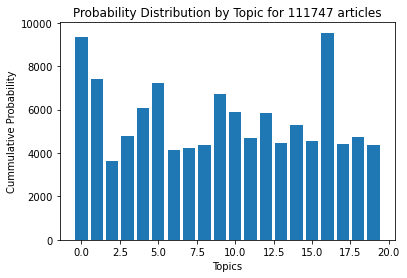

In [132]:
plt.bar(range(20), total)
plt.xlabel('Topics')
plt.ylabel('Cummulative Probability')
plt.title('Probability Distribution by Topic for 111747 articles')
plt.savefig("prob_distribution.png")

# Plot: Topic Weights based on month: January vs May

In [134]:
# segment data by month: January, May
df_40_5months_jan = df_40_5months[df_40_5months['date'].dt.month == 1]
df_40_5months_may = df_40_5months[df_40_5months['date'].dt.month == 5]

print(df_40_5months_jan.shape)
print(df_40_5months_jan.index)
print(df_40_5months_may.shape)
print(df_40_5months_may.index)
print(df_40_5months.shape) # 111747 documents total, so there should be about a fifth of this in a given month

(21972, 7)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            21962, 21963, 21964, 21965, 21966, 21967, 21968, 21969, 21970,
            21971],
           dtype='int64', length=21972)
(22092, 7)
Int64Index([ 89655,  89656,  89657,  89658,  89659,  89660,  89661,  89662,
             89663,  89664,
            ...
            111737, 111738, 111739, 111740, 111741, 111742, 111743, 111744,
            111745, 111746],
           dtype='int64', length=22092)
(111747, 7)


<BarContainer object of 20 artists>

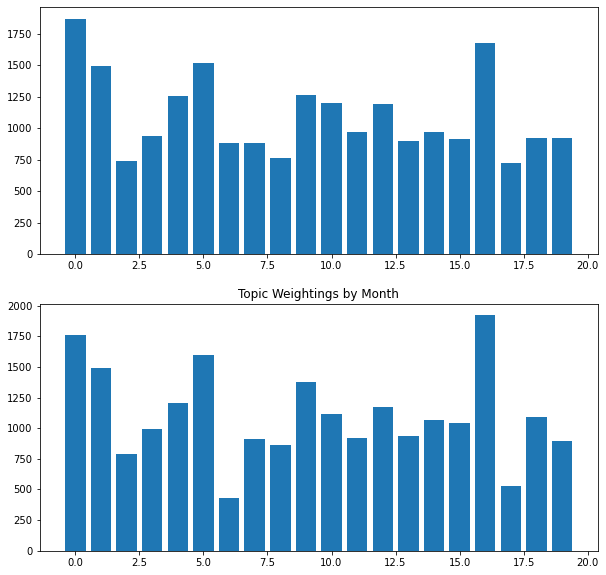

In [137]:
fig, ax = plt.subplots(2,1, figsize = (10,10)) # ax is an array
plt.title('Topic Weightings by Month')
ax[0].bar(range(20), np.sum(lda_topics[df_40_5months_jan.index], axis = 0))
ax[1].bar(range(20), np.sum(lda_topics[df_40_5months_may.index], axis = 0))

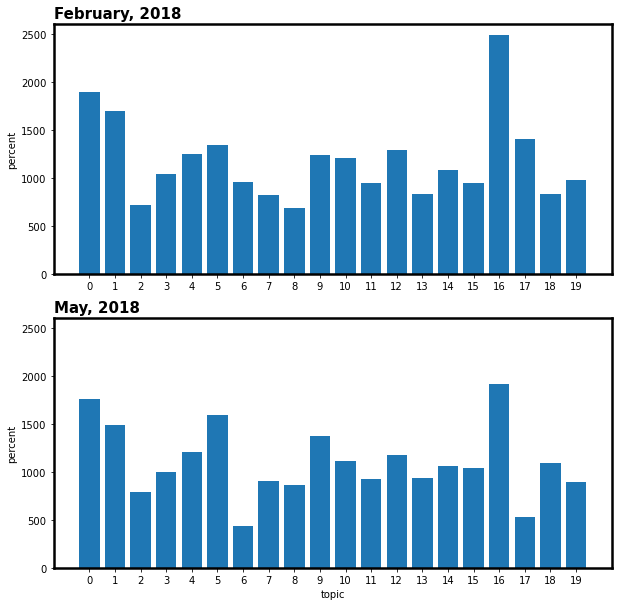

In [210]:
# df_40_5months_jan = df_40_5months[df_40_5months['date'].dt.month == 1]
# df_40_5months_may = df_40_5months[df_40_5months['date'].dt.month == 5]


fig, ax = plt.subplots(2,1, figsize = (10,10), gridspec_kw = {'wspace': 0.05, 'hspace':0.18})
# fig.suptitle('Topic Distribution by Month', y=1.00, fontsize=35)

ax[0].set_title('February, 2018', fontweight ="bold", loc='left', fontsize=15)
ax[0].bar(range(20), np.sum(lda_topics[df_40_5months[df_40_5months['date'].dt.month == 2].index], axis = 0))
ax[0].set_xticks(list(range(20)))
ax[0].set_xticklabels(list(range(20)))
# ax[0].set_xlabel('topic')
ax[0].set_ylim(0, 2600)
ax[0].set_ylabel('percent')

ax[1].set_title('May, 2018', fontweight ="bold", loc='left', fontsize=15)
ax[1].bar(range(20), np.sum(lda_topics[df_40_5months_may.index], axis = 0))
ax[1].set_xticks(list(range(20)))
ax[1].set_xticklabels(list(range(20)))
ax[1].set_xlabel('topic')
ax[1].set_ylim(0, 2600)
ax[1].set_ylabel('percent')
plt.savefig('01_Topic_Distribution_by_Month.png')

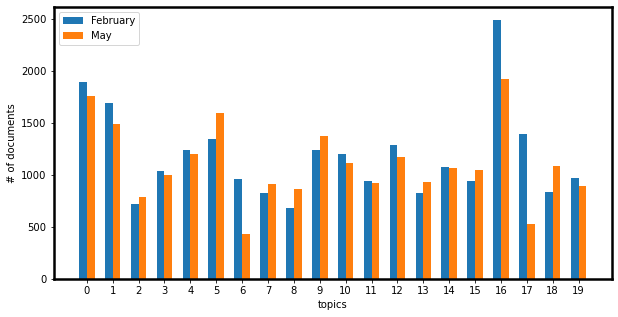

In [238]:
# the code in this cell was taken and modified from this website: https://stackoverflow.com/questions/10369681/how-to-plot-bar-graphs-with-same-x-coordinates-side-by-side-dodged

# Numbers of pairs of bars you want
N = 20

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = np.sum(lda_topics[df_40_5months[df_40_5months['date'].dt.month == 2].index], axis = 0)
# Specify the values of orange bars (height)
orange_bar = np.sum(lda_topics[df_40_5months_may.index], axis = 0)
                    
# Position of bars on x-axis
ind = np.arange(20)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='February')
plt.bar(ind + width, orange_bar, width, label='May')

plt.xlabel('topics')
plt.ylabel('# of documents')
# plt.title('Topic Distribution by Month')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, (np.arange(20)))

# Finding the best position for legends and putting it
plt.legend(loc=2)
plt.savefig('01_Topic_Distribution_by_Month_sideByside.png')
plt.show()


# Plot: Topic Distribution by Character Count
- compare topic weightings by character lenghth: 280 and under characters vs >280 characters

In [138]:
df_40_5months['characters'] = df_40_5months.text.apply(lambda x: len(x))
df_40_5months

,title,text,date,wordcount,processed,lemma_stop,dominant_topic,characters
0,BRIEF-Wuhan Fingu Electronic Technology Elects Chairman,Jan 15 (Reuters) - Wuhan Fingu Electronic Technology Co Ltd :\n* SAYS BOARD ELECTS MENG FANBO AS CHAIRMAN Source text in Chinese: bit.ly/2FDdonX Further company coverage: (Reporting by Hong Kong newsroom)\n,2018-01-15 17:46:00+00:00,32,jan reuters wuhan fingu electronic technology co ltd says board elects meng fanbo as chairman source text in chinese bit ly fddonx further company coverage reporting by hong kong newsroom,board chairman bit,6,205
1,BRIEF-create restaurants holdings plans business and capital alliance with Tokyo-based firm,"Jan 12 (Reuters) - create restaurants holdings inc :\n* Says co plans to form a business and capital alliance with Tokyo-based firm, which is mainly engaged in management of a restaurant brand\n* Co will inject capital in the Tokyo-based firm, via private placement plan offer by it, on Jan. 31\nSource text in Japanese: goo.gl/nZwVDr\nFurther company coverage: (Beijing Headline News)\n",2018-01-12 14:51:00+00:00,63,jan reuters create restaurants holdings inc says co plans to form a business and capital alliance with tokyo based firm which is mainly engaged in management of a restaurant brand co will inject capital in the tokyo based firm via private placement plan offer by it on january source text in japanese goo gl nzwvdr further company coverage beijing headline news,restaurant business capital alliance firm management restaurant brand co capital firm placement plan offer goo nzwvdr headline news,6,383
2,「おふざけコイン」も高騰、仮想通貨の乱高下に注意 - WSJ,"DOW JONES, A NEWS CORP COMPANY News Corp is a network of leading companies in the worlds of diversified media, news, education, and information services. DOW JONES",2018-01-17 23:37:00+00:00,27,dow jones a news corp company news corp is a network of leading companies in the worlds of diversified media news education and information services dow jones,network world medium news education service,1,164
3,EU's Moscovici confident of Greek reform review conclusion on Monday,"BRUSSELS, Jan 22 (Reuters) - Euro zone finance ministers should be able to agree on Monday that Greece has made sufficient progress to merit the disbursement of new loans, European Commissioner for Economic and Monetary Union Pierre Moscovici said.\n“I‘m quite confident that, on the basis of the good work that has been made on prior actions voted ... in the Greek parliament, we will conclude today the third review of the programme Greece,” Moscovici said before a meeting of the ministers in Brussels.\n“That means we need to prepare the conclusion of the programme as such and not only a conclusion but a successful conclusion. That means Greece being back as a normal member of the euro zone and the final signal, the end of the Greek crisis.” (Reporting by Philip Blenkinsop)\n",2018-01-22 20:22:00+00:00,133,brussels jan reuters euro zone finance ministers should be able to agree on monday that greece has made sufficient progress to merit the disbursement of new loans european commissioner for economic and monetary union pierre moscovici said i m quite confident that on the basis of the good work that has been made on prior actions voted in the greek parliament we will conclude today the third review of the programme greece moscovici said before a meeting of the ministers in brussels that means we need to prepare the conclusion of the programme as such and not only a conclusion but a successful conclusion that means greece being back as a normal member of the euro zone and the final signal the end of the greek crisis reporting by philip blenkinsop,finance minister progress disbursement loan basis work action parliament today review programme meeting minister conclusion programme conclusion conclusion member zone signal end crisis blenkinsop,5,782
4,BRIEF-Fujian Sunnada Communication amends FY 2017 net profit outlook,"Jan 30(Reuters) - Fujian Sunnada Communication Co Lt

In [233]:
df_under_281 = df_40_5months[df_40_5months.characters < 281]
df_under_281

,title,text,date,wordcount,processed,lemma_stop,dominant_topic,characters
0,BRIEF-Wuhan Fingu Electronic Technology Elects Chairman,Jan 15 (Reuters) - Wuhan Fingu Electronic Technology Co Ltd :\n* SAYS BOARD ELECTS MENG FANBO AS CHAIRMAN Source text in Chinese: bit.ly/2FDdonX Further company coverage: (Reporting by Hong Kong newsroom)\n,2018-01-15 17:46:00+00:00,32,jan reuters wuhan fingu electronic technology co ltd says board elects meng fanbo as chairman source text in chinese bit ly fddonx further company coverage reporting by hong kong newsroom,board chairman bit,6,205
2,「おふざけコイン」も高騰、仮想通貨の乱高下に注意 - WSJ,"DOW JONES, A NEWS CORP COMPANY News Corp is a network of leading companies in the worlds of diversified media, news, education, and information services. DOW JONES",2018-01-17 23:37:00+00:00,27,dow jones a news corp company news corp is a network of leading companies in the worlds of diversified media news education and information services dow jones,network world medium news education service,1,164
7,Will Korean Olympics Solidarity Unsettle U.S.?,"Not only will North Korea send athletes to the Winter Olympics in South Korea, but the two countries' athletes will march under the same flag as well. WSJ's Gerald F. Seib explains how the cooperation affects U.S. policy towards Pyongyang and its nuclear threat. Photo: Getty",2018-01-18 00:00:00+00:00,46,not only will north korea send athletes to the winter olympics in south korea but the two countries athletes will march under the same flag as well wsj s gerald f seib explains how the cooperation affects you s policy towards pyongyang and its nuclear threat photo getty,athlete winter olympic country athlete flag seib cooperation policy threat photo getty,1,275
9,BRIEF-Union Medical Healthcare ‍Company Proposes Issue Of USD Denominated Bonds,Jan 19 (Reuters) - Union Medical Healthcare Ltd:\n* ‍COMPANY PROPOSES TO CONDUCT AN INTERNATIONAL OFFERING OF BONDS TO PROFESSIONAL INVESTORS ONLY​ Source text for Eikon: Further company coverage:\n,2018-01-19 10:56:00+00:00,29,jan reuters union medical healthcare ltd company proposes to conduct an international offering of bonds to professional investors only source text for eikon further company coverage,offering bond investor,19,197
15,"CNBC Tech Check Morning Edition: January 02, 2018","CNBC Tech Check Morning Edition: January 02, 2018 1 Hour Ago CNBC’s Tech Check brings you the latest in tech news from CNBC’s 1 Market in the heart of San Francisco.",2018-01-02 16:22:00+00:00,31,cnbc tech check morning edition january hour ago cnbc s tech check brings you the latest in tech news from cnbc s market in the heart of san francisco,tech morning edition hour tech check news heart,8,165
...,...,...,...,...,...,...,...,...
111710,This CEO says schools today are 'trained to teach the past',This CEO says schools today are 'trained to teach the past' 8 Hours Ago Yat Siu of Outblaze says parents should get their children to think about the problems that they want to solve instead of what kind of job they want to do.,2018-05-23 01:55:00+00:00,44,this ceo says schools today are trained to teach the past hours ago yat siu of outblaze says parents should get their children to think about the problems that they want to solve instead of what kind of job they want to do,ceo school today hour outblaze parent child problem kind job,7,227
111714,Agile Therapeutics Reports Q1 Loss Per Share $0.20,May 7 (Reuters) - Agile Therapeutics Inc:\n* AGILE THERAPEUTICS REPORTS FIRST QUARTER 2018 FINANCIAL RESULTS\n* Q1 LOSS PER SHARE $0.20 * Q1 EARNINGS PER SHARE VIEW $-0.20 — THOMSON REUTERS I/B/E/S Source text for Eikon:\nOur,2018-05-08 01:48:00+00:00,38,may reuters agile therapeutics inc agile therapeutics reports first quarter financial results q loss per share q earnings per share view thomson reuters i b e s source text for eikon our,therapeutic report quarter result q loss share earning share view,16,223
111715,G.A. Holdings Posts Qtrly Profit Attributable To Owne

In [234]:
df_over_280 = df_40_5months[df_40_5months.characters > 280] # recall we filtered by word count >25 words and < 1000 words, now we're filtering by characters
df_over_280

,title,text,date,wordcount,processed,lemma_stop,dominant_topic,characters
1,BRIEF-create restaurants holdings plans business and capital alliance with Tokyo-based firm,"Jan 12 (Reuters) - create restaurants holdings inc :\n* Says co plans to form a business and capital alliance with Tokyo-based firm, which is mainly engaged in management of a restaurant brand\n* Co will inject capital in the Tokyo-based firm, via private placement plan offer by it, on Jan. 31\nSource text in Japanese: goo.gl/nZwVDr\nFurther company coverage: (Beijing Headline News)\n",2018-01-12 14:51:00+00:00,63,jan reuters create restaurants holdings inc says co plans to form a business and capital alliance with tokyo based firm which is mainly engaged in management of a restaurant brand co will inject capital in the tokyo based firm via private placement plan offer by it on january source text in japanese goo gl nzwvdr further company coverage beijing headline news,restaurant business capital alliance firm management restaurant brand co capital firm placement plan offer goo nzwvdr headline news,6,383
3,EU's Moscovici confident of Greek reform review conclusion on Monday,"BRUSSELS, Jan 22 (Reuters) - Euro zone finance ministers should be able to agree on Monday that Greece has made sufficient progress to merit the disbursement of new loans, European Commissioner for Economic and Monetary Union Pierre Moscovici said.\n“I‘m quite confident that, on the basis of the good work that has been made on prior actions voted ... in the Greek parliament, we will conclude today the third review of the programme Greece,” Moscovici said before a meeting of the ministers in Brussels.\n“That means we need to prepare the conclusion of the programme as such and not only a conclusion but a successful conclusion. That means Greece being back as a normal member of the euro zone and the final signal, the end of the Greek crisis.” (Reporting by Philip Blenkinsop)\n",2018-01-22 20:22:00+00:00,133,brussels jan reuters euro zone finance ministers should be able to agree on monday that greece has made sufficient progress to merit the disbursement of new loans european commissioner for economic and monetary union pierre moscovici said i m quite confident that on the basis of the good work that has been made on prior actions voted in the greek parliament we will conclude today the third review of the programme greece moscovici said before a meeting of the ministers in brussels that means we need to prepare the conclusion of the programme as such and not only a conclusion but a successful conclusion that means greece being back as a normal member of the euro zone and the final signal the end of the greek crisis reporting by philip blenkinsop,finance minister progress disbursement loan basis work action parliament today review programme meeting minister conclusion programme conclusion conclusion member zone signal end crisis blenkinsop,5,782
4,BRIEF-Fujian Sunnada Communication amends FY 2017 net profit outlook,"Jan 30(Reuters) - Fujian Sunnada Communication Co Ltd :\n* Says net profit for FY 2017 to be 2 million yuan to 10 million yuan\n* Says in the previous outlook, the company expected the net profit for FY 2017 to be 10 million yuan to 20 million yuan\n* Says the net profit of FY 2016 was 105.4 million yuan\nSource text in Chinese: goo.gl/Az4Eod\nFurther company coverage: (Beijing Headline News)\n",2018-01-30 12:19:00+00:00,72,jan reuters fujian sunnada communication co ltd says net profit for fy to be million yuan to million yuan says in the previous outlook the company expected the net profit for fy to be million yuan to million yuan says the net profit of fy was million yuan source text in chinese goo gl az eod further company coverage beijing headline news,profit yuan yuan outlook profit yuan yuan profit yuan eod headline news,6,392
5,The Wall Street Journal: Shari Redstone wants new CBS directors amid renewed push to merge company with Viacom,"08 p.m. ET Share \nShari Redstone re

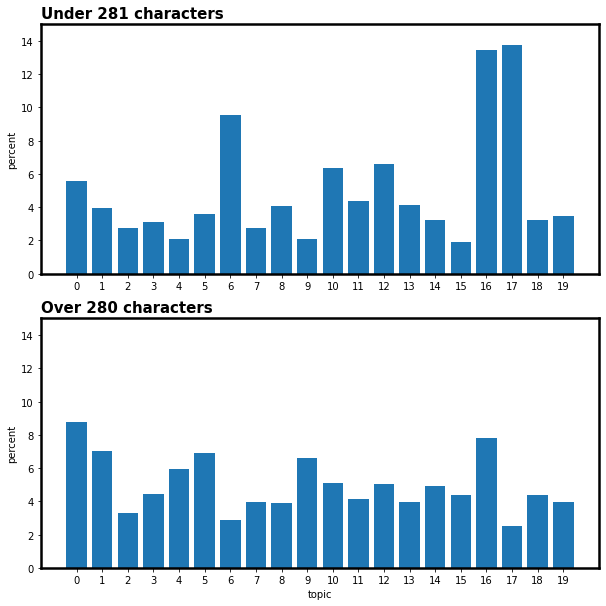

In [235]:
fig, ax = plt.subplots(2,1, figsize = (10,10), gridspec_kw = {'wspace': 0.05, 'hspace':0.18})
# fig.suptitle('Topic Distribution by Character Count', y=1.00, fontsize=35)

ax[0].set_title('Under 281 characters', fontweight ="bold", loc='left', fontsize=15)
ax[0].bar(range(20), (np.sum(lda_topics[df_under_281.index], axis = 0) / np.sum(np.sum(lda_topics[df_under_281.index]), axis = 0))*100) # don't need to have nested np.sum... instead I can just not feed in axis = 0 and it'll just sum up everything
ax[0].set_xticks(list(range(20)))
ax[0].set_xticklabels(list(range(20)))
# ax[0].set_xlabel('topic')
ax[0].set_ylim(0, 15)
ax[0].set_ylabel('percent')

ax[1].set_title('Over 280 characters', fontweight ="bold", loc='left', fontsize=15)
ax[1].bar(range(20), (np.sum(lda_topics[df_over_280.index], axis = 0) / np.sum(np.sum(lda_topics[df_over_280.index]), axis = 0))*100)
ax[1].set_xticks(list(range(20)))
ax[1].set_xticklabels(list(range(20)))
ax[1].set_xlabel('topic')
ax[1].set_ylim(0, 15)
ax[1].set_ylabel('percent')
plt.savefig('Topic_Distribution_by_Character_Count.png')

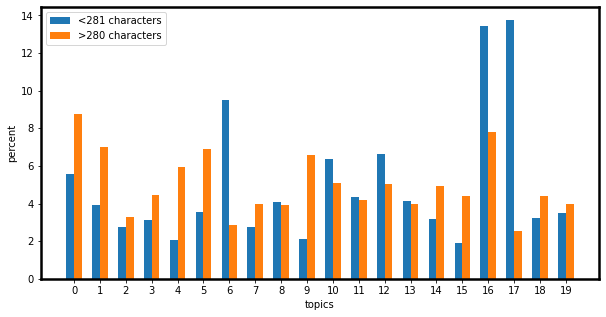

In [240]:
# the code in this cell was taken and modified from this website: https://stackoverflow.com/questions/10369681/how-to-plot-bar-graphs-with-same-x-coordinates-side-by-side-dodged

# Numbers of pairs of bars you want
N = 20

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = ((np.sum(lda_topics[df_under_281.index], axis = 0) / np.sum(np.sum(lda_topics[df_under_281.index]), axis = 0))*100)
# Specify the values of orange bars (height)
orange_bar = ((np.sum(lda_topics[df_over_280.index], axis = 0) / np.sum(np.sum(lda_topics[df_over_280.index]), axis = 0))*100)
                    
# Position of bars on x-axis
ind = np.arange(20)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='<281 characters')
plt.bar(ind + width, orange_bar, width, label='>280 characters')

plt.xlabel('topics')
plt.ylabel('percent')
# plt.title('Topic Distribution by Month')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, (np.arange(20)))

# Finding the best position for legends and putting it
plt.legend(loc=2)
plt.savefig('00_Topic_Distribution_by_Characters_280.png')
plt.show()

# WordCloud

In [150]:
# WordCloud

from wordcloud import WordCloud # wordcloud is a module, WordCloud is class within that module

# for each topic we're gonna build a list of tuples: first element is the word, second is it's probability

def word_cloud_topwrds(model, feature_names, no_top_words): # feature name is the word; no_top_words... e.g. top 10 words... 
    topic_term_frequency_lists = [] # list of dictionaries (20 dictionaries for number of topics)

    
    
    # model.components_ <-- for each topic what is the score for each word for that topic. rows are the topics (20) and columns are the features/words.
    
    for topic in model.components_: # topic = list of weights for each term; topic_idx = current row that you're working with
        top_word_idx = topic.argsort()[:-no_top_words - 1:-1]
            
# "topic" has the probabilities in there, list of probabilities for each term.; argsort gives the indexes of most relevant row of that topic; indexes of the highest scores...
        top_features = list() 
        
        #feature_names[top_word_idx] # if it's a numpy array, but can't do it because it's a python list
        for i in top_word_idx:
            top_features.append(feature_names[i])
        
        top_scores = list()
        for i in top_word_idx:
            top_scores.append(topic[i])
        
        tmp_dct = dict()
        for k, v in zip(top_features,top_scores):
            tmp_dct[k] = v

        topic_term_frequency_lists.append(tmp_dct)    
    return topic_term_frequency_lists
        
no_top_words = 50
cld = word_cloud_topwrds(lda_model, tf_feature_names, no_top_words) # feature name is the word (so we know what term the component is referring to)

In [151]:
type(tf_feature_names) # term frequency

list

In [152]:
cld

[{'service': 21728.036935479206,
  'business': 21639.42686649552,
  'technology': 15472.979808711909,
  'product': 14916.961006602021,
  'call': 14597.261218921041,
  'customer': 14582.697777360067,
  'solution': 11489.383153525263,
  'industry': 11404.14235973616,
  'conference': 11064.182541501179,
  'management': 10787.517146917737,
  'officer': 10714.188872422554,
  'president': 10387.141208577037,
  'investor': 9385.249829294087,
  'team': 9177.777314562501,
  'experience': 8522.594760047865,
  'director': 8069.037279396393,
  'client': 8026.18579440736,
  'today': 7892.765412322443,
  'conference call': 7615.605369503403,
  'growth': 7560.3774620468075,
  'vice': 7066.45105902254,
  'result': 6930.576504145833,
  'board': 6724.448152738624,
  'development': 6429.191005942187,
  'website': 6289.490002874649,
  'partner': 6125.3095129973035,
  'relation': 6089.621980636371,
  'vice president': 5894.4874642028335,
  'system': 5560.5230016230435,
  'provider': 5532.010816483726,
  'c

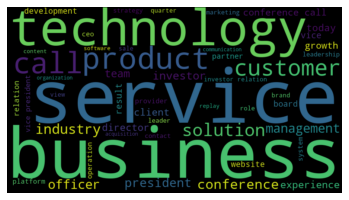

In [153]:
wordcloud = WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(cld[0])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

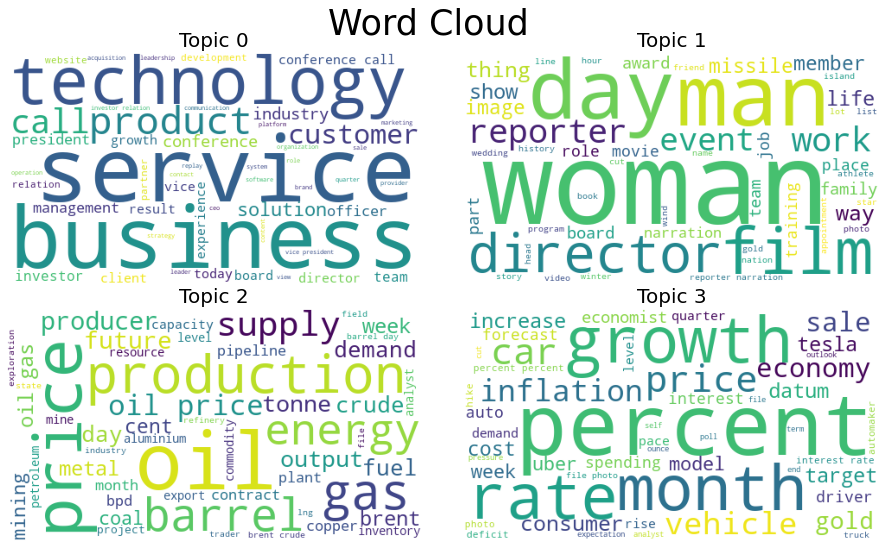

In [199]:
cloud = WordCloud(width = 480, height = 270, background_color ='white')
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (16,9), gridspec_kw = {'wspace': 0.05, 'hspace':0.1}) # share x and y <-- say that the subplots will share axis, <figsize>, etc)
plt.suptitle('Word Cloud', y=0.95, fontsize=35)
plt.rcParams["axes.edgecolor"] = "black" # add outline on subplots, doesn't work; over-ridden by WordCloud?
plt.rcParams["axes.linewidth"] = 2.50 # not sure if it's doing anything, overridden by WordCloud?
for i, axes in enumerate(axes.flatten()):
    fig.add_subplot(axes)
    topic_words = cld[i]
    cloud.generate_from_frequencies(topic_words)
    plt.gca().set_title('Topic '+str(i), fontdict=dict(size=20)) # gca = get current axis
    plt.gca().axis('off')
    plt.gca().imshow(cloud)
plt.savefig('wordcloud.png')

# Recommender

In [102]:
from sklearn.metrics.pairwise import cosine_similarity

In [106]:
dtm.shape

(111747, 69710)

In [103]:
%%time
similarity_matrix = cosine_similarity(dtm) # this does pairwise distances for every document n^2 times time complexity

# n by n matrix... for each document similarity score between 0 and 1
# this takes too long. so just do it for one of the douments. at a time. time complexity of n times...
# index into dtm for that document number
# write a for loop that calculates similarity between that document and every other document
# save it as a list, and return the highest similarity score, excluding the score with itself... which would equal 1

MemoryError: Unable to allocate 51.0 GiB for an array with shape (6846264736,) and data type float64

## n x n (document x document) similarity matrix could be calculated created for Jan only, but 5 months of documents is too much data, says I need 51gigs of memory.
- so, I need to modify the recommender function (below). I need to created a n x 1 similarity matrix every time I look up a document for recommendation, instead of having all the scores calculated for every combination ahead of time.

In [104]:
similarity_matrix

NameError: name 'similarity_matrix' is not defined

In [107]:
# Let's call a document and use recommender to recomment 10 most similar by cosine similarity we'll use document 0
df_40_5months.iloc[0,:][['title', 'text', 'date']]

title    BRIEF-Wuhan Fingu Electronic Technology Elects...
text     Jan 15 (Reuters) - Wuhan Fingu Electronic Tech...
date                             2018-01-15 17:46:00+00:00
Name: 0, dtype: object

In [ ]:
# old recommender that worked for Jan only, needs n x n similarity matrix, won't work because I can't create one for 5 months of documents (too many, not enough memory)
# need to modify this recommender, new recommender function is called 'recommend2'

def recommend(matrix, doc_num, top_num): # doc_num is the name of the iloc of the document we want to look up (for recommendation)
    scores = matrix[doc_num] # should be an np.array
    return np.argsort(scores)[-(top_num + 1) :], scores[[np.argsort(scores)[-(top_num + 1) :]]] # returns as tuple; set ending value to -1 to cut off the similarity of 1 which is with itself (i.e. -1 to not display the document we are inputing)

top_10_index, top_10_scores = recommend(similarity_matrix, 5, 10) # see top 10 recommendations for document 0
print(top_10_scores)

df_scores = df_40_5months.iloc[top_10_index,:][['title', 'text', 'date']] # iloc is more robust; if I want to use loc, then I need to reset_index like I did above.
df_scores['scores'] = top_10_scores
df_scores.sort_values('scores', ascending=False)
#np.fill to get rid of diagonal with cosine similarity of 1 (i.e. comparing document to itself)

In [ ]:
df_40_5months.iloc[top_10_index,:][['title', 'text', 'date']] # same as when we use .loc because we reset index

In [ ]:
len(top_10_index)
top_10_index

In [ ]:
# This is the document for which the above 10 article recommendations were made:
df_40_5months.loc[0,:][['title', 'text', 'date']]

# cosine similarity matrix works for Jan data but not for all 5 months not enough memory

In [118]:
%%time
similarity_matrix_tmp = cosine_similarity(dtm,dtm[1]) # n by 1 for the second document

Wall time: 372 ms


In [119]:
similarity_matrix_tmp # numpy array of arrays, kind of like a list of lists, inner list only has 1 element because it's an n by 1 matrix, outer list represents 1 document and inner lists are the scores between input document and all other documents; recall for n by n matrix it was still list of lists but the inner list had many elements, the other list represented many documents, the inner list represented each document, and the members of the inner list represented scores between all the combinations.

array([[0.        ],
       [1.        ],
       [0.05986843],
       ...,
       [0.06699312],
       [0.01120347],
       [0.        ]])

In [120]:
similarity_matrix_tmp.shape

(111747, 1)

In [116]:
type(similarity_matrix_tmp)

numpy.ndarray

In [113]:
similarity_matrix_tmp[5]

array([0.])

In [121]:
type(similarity_matrix_tmp[5])

numpy.ndarray

In [122]:
flattened_similarity_matrix_tmp = np.concatenate(similarity_matrix_tmp).ravel()
flattened_similarity_matrix_tmp

array([0.        , 1.        , 0.05986843, ..., 0.06699312, 0.01120347,
       0.        ])

In [126]:
pd.options.display.max_colwidth = 2000 # display.max_colwidth sets the maximum width of columns. Cells of this length or longer will be truncated with an ellipsis.
pd.options.display.max_columns = 500 # max_columns sets the maximum number of rows and columns displayed when a frame is pretty-printed. Truncated lines are replaced by an ellipsis.

def recommend2(document_term_matrix, doc_num, top_num): # doc_num is the name of the iloc of the document we want to look up (for recommendation)
    sim_matrix = cosine_similarity(document_term_matrix, document_term_matrix[doc_num])
    flattened_sim_matrix = np.concatenate(sim_matrix).ravel()
    return np.argsort(flattened_sim_matrix)[-(top_num + 1) :], flattened_sim_matrix[[np.argsort(flattened_sim_matrix)[-(top_num + 1) :]]] # returns as tuple; set ending value to -1 to cut off the similarity of 1 which is with itself (i.e. -1 to not display the document we are inputing)

top_10_index, top_10_scores = recommend2(dtm, 5, 10) # see top 10 recommendations for document 0
print(top_10_scores)

df_scores = df_40_5months.iloc[top_10_index,:][['title', 'text', 'date']] # iloc is more robust; if I want to use loc, then I need to reset_index like I did above.
df_scores['scores'] = top_10_scores
df_scores.sort_values('scores', ascending=False)
#np.fill to get rid of diagonal with cosine similarity of 1 (i.e. comparing document to itself)

[0.26575836 0.26700899 0.27994168 0.28354659 0.29563437 0.30756234
 0.33946737 0.34743387 0.35588067 0.36348619 1.        ]


<ipython-input-126-3034abe1d9d7>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.argsort(flattened_sim_matrix)[-(top_num + 1) :], flattened_sim_matrix[[np.argsort(flattened_sim_matrix)[-(top_num + 1) :]]] # returns as tuple; set ending value to -1 to cut off the similarity of 1 which is with itself (i.e. -1 to not display the document we are inputing)


,title,text,date,scores
5,The Wall Street Journal: Shari Redstone wants new CBS directors amid renewed push to merge company with Viacom,"08 p.m. ET Share \nShari Redstone reached out to CBS Chief Executive Leslie Moonves to jump-start talks about merging CBS and Viacom—potentially as soon as this quarter Getty Images Shari Redstone, vice chairman of Viacom and CBS, at the Allen & Company Sun Valley Conference in 2016 \nBy Keach Hagey Joe Flint \nShari Redstone is advocating for new blood on the board of CBS Corp. as she renews her push to merge the company with Viacom Inc., according to people familiar with the matter. \nEarlier this month, Ms. Redstone reached out to CBS Chief Executive Leslie Moonves to jump-start talks about merging CBS CBS, -1.33% and Viacom VIAB, +1.04% —potentially as soon as this quarter, the people said. \nMs. Redstone reluctantly pulled the plug on an earlier exploration of such a combination in late 2016, but she has never stopped believing that the deal made sense, the people said. She saw the recent wave of consolidation in the media industry—particularly 21st Century Fox’s FOXA, +1.71% agreement to sell most of its assets to Walt Disney Co. DIS, +1.03% —as a clear sign that bulking up is more urgent than ever, the people said. \n“I think she has a real interest in seeing this merger move forward,” said one person familiar with her thinking.",2018-01-17 20:08:00+00:00,1.000000
76638,"Redstone likely to replace Moonves as head of CBS if no deal with Viacom, sources say","5 Hours Ago | 04:09 \nShari Redstone, whose National Amusements controls CBS and Viacom, is likely to replace CBS CEO Les Moonves if a deal isn't reached between the two companies as the media tie-up hits an impasse, sources familiar with the situation said. \nCBS is expected to make another offer soon, the sources said, but that new bid was expected to fall short on price. The amount of synergy expected by CBS is well below that of Viacom. \nThe main obstacle to the rejoining of the network and owner of Nickelodeon and MTV is a growing distrust between Redstone and Moonves. As CNBC previously reported , Moonves wants to pick his own management team if he is to head the combined entity and favors Joe Ianniello, chief operating officer of CBS, as his key lieutenant. Redstone, however, wants Bob Bakish, the current CEO of Viacom, as No. 2. CNBC | Getty Images Leslie Moonves, Chairman and CEO of CBS Corporation (l) and Shari Redstone Vice Chairperson of Viacom. \nRedstone is also expected to replace the CBS board if a deal isn't reached, the sources said. \nPreviously, Moonves was believed to have agreed with Redstone to run the combined company for at least two years. \n""National Amusements has tremendous respect for Les Moonves and it has always been our intention that he run a combined company,"" the holding company said in a statement. \nCBS shares were down 1.5 percent on Wednesday and Viacom shares were off by 1 percent. National Amusements, founded by Redstone's father, Sumner, owns an 80 percent of each company. \n""The industry and the marketplace know Leslie Moonves' record and we think it speaks for itself,"" CBS said in a statement in response to this story. show chapters",2018-04-11 13:37:00+00:00,0.363486
106699,Exclusive - Redstone makes concessions on Viacom CEO to clinch CBS merger - sources,"May 4, 2018 / 7:16 PM / Updated 14 minutes ago Exclusive - Redstone makes concessions on Viacom CEO to clinch CBS merger - sources Jessica Toonkel 3 Min Read\n(Reuters) - Shari Redstone, the media heiress whose family controls CBS Corp ( CBS.N ) and Viacom Inc ( VIAB.O ), has offered CBS CEO Leslie Moonves to drop her demands for Viacom CEO Bob Bakish to be his No. 2 following a merger, as long as Bakish sits on the combined company’s board, people familiar with the matter told Reuters on Friday. FILE PHOTO - Shari Redstone arrives for Variety's Power of Women luncheon in New York City, U.S., April 21, 2017. REUTERS/Brendan McDe

# skip. practice: processing and nmf

In [ ]:
# directory = "sample of JSONs for 1 month"
# json_files = os.listdir("sample of JSONs for 1 month")
# len(json_files)

In [ ]:
# lst_dct = list()
# for file in json_files:
#     temp_dct = dict()
#     article = json.load(open(os.path.join(directory,file), encoding='utf8'))
    
#     # UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 2608: character maps to <undefined>
#     # it's trying to convert to ascii, but can't decode something,
    
#     temp_dct['title'] = article['title']
#     temp_dct['text'] = article['text']
#     temp_dct['date'] = article['published']
#     lst_dct.append(temp_dct)

In [ ]:
# df = pd.DataFrame(lst_dct)

In [ ]:
# df

In [ ]:
# df.loc[249]

In [ ]:
# df2 = df.set_index('title')

In [ ]:
# df2.head()

In [ ]:
# df2.loc["U.S. judge orders government to release Iraqis or grant bond hearings"]

In [ ]:
# stp_wrds = stopwords.words('english')

In [ ]:
### Find additional stop words
### data = df.text.to_list()

### data = [text.split() for text in data]
### Flatten list
### data = [wrd.lower() for text in data for wrd in text]

### Filter out stop words
### data = filter((lambda wrd: wrd not in stp_wrds), data)

### word_count = Counter(data)

In [ ]:
###stp_wrds.add('said')

In [ ]:
###string.punctuation

In [ ]:
###sorted(word_count.items(), key=(lambda x: x[1]))

In [ ]:
# Start with a collection of documents (List of string)
# Tokenize each document (List of List of strings)
# Convert each token to lowercase, remove stop words, stem/lemmatize tokens (List of list of strings)
# Concatenate the each list of strings back into 1 string (List of string)
# Feed that into tfidf vectorizer

In [ ]:
## Tokensize
## convert to lowercase
## remove punctuation
## compute tfidf vectors
##  - generate vocabulary
##  - 
# vectorizer = TfidfVectorizer(stop_words=stp_wrds) # set min and min df, (1,2)
# X = vectorizer.fit_transform(df.text)

In [ ]:
# vectorizer.vocabulary_ # values are id values, not count

In [ ]:
# X

In [ ]:
# X.toarray()

# NMF

In [ ]:
nmf = NMF(n_components=3)
nmf.fit(dtm)

In [ ]:
# W = nmf.transform(X)
# H = nmf.components_

In [ ]:
# W

In [ ]:
# H

In [ ]:
# cell deleted accidentally, look up. output is a list of words (in order of popularity?)

In [ ]:
# H = pd.DataFrame(H, columns=list(vectorizer.vocabulary_.keys()))
# W = pd.DataFrame(W)

In [ ]:
# H.iloc[0].sort_values(ascending=False)[:20]

In [ ]:
# H.iloc[1].sort_values(ascending=False)[:20]

In [ ]:
# H.iloc[2].sort_values(ascending=False)[:20]

In [ ]:
## testList = [1, 3, 2, 5, 9, 12, 83]

In [ ]:
# def isGreaterThanFour(x):
#     return x > 4

In [ ]:
# list(map(isGreaterThanFour, testList))

In [ ]:
# list(map((lambda x: x > 4),  testList))

In [ ]:
# someData = df.head(15)

In [ ]:
# someData[[True, True, False, False, True, False, True, False, True, True, True, True, False, False, False]]

In [ ]:
print("DONE!!!")